# Merge MTBS Dataset with California County Data

In [16]:
#!pip install descartes

In [17]:
#!pip install geopandas --upgrade

In [18]:
import matplotlib.pyplot as plt
import numpy as np 


from shapely.geometry import Point,Polygon
import geopandas as gpd
import descartes
import pandas as pd
import glob
import os
from functools import reduce
import seaborn as sns
import rasterio
import rasterio.plot
import rioxarray as rxr
import rioxarray as rxr

In [19]:
usa_counties = gpd.read_file("tl_2019_us_county/tl_2019_us_county.shp")

In [20]:
usa_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680962890,61582307,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016819475,29089486,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169270569,22849484,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645188,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


<AxesSubplot:>

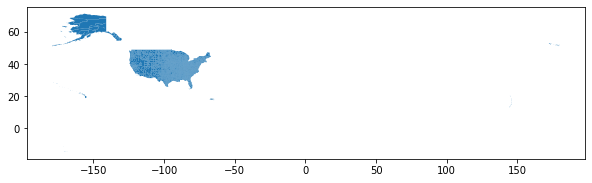

In [21]:
# magic command for using matplotlib, next plot state geometries
%matplotlib inline
usa_counties.plot(figsize=(10,10))

In [22]:
fires = gpd.read_file("WFDSSHistoricFirePerimeters_2020/WFDSSHistoricFirePerimeters_2020.shp")

In [23]:
fires.head()

,OBJECTID,INCIDENT,FIRE_YEAR_,FIRE_YEAR,AGENCY,SOURCE,DATE_CUR,MAP_METHOD,GIS_ACRES,COMMENTS,UNQE_FIRE_,LOCAL_NUM,UNIT_ID,USER_NAME,GEO_ID,SHAPE_Leng,SHAPE_Area,geometry
0,7348,VICS PEAK,2020,2020,USFS,WFDSS,20200714,Infrared,14617.6,None,2020-NMCIF-000223,000223,NMCIF,Molly Wright,4126487,1.812773,0.005747,"MULTIPOLYGON (((-107.45431 33.61050, -107.4542..."
1,7349,Cub,2020,2020,USFS,WFDSS,20200715,Infrared,21494.3,None,2020-NMGNF-000343,000343,NMGNF,Shelly Crook,4100025,1.832110,0.008422,"MULTIPOLYGON (((-108.53574 33.31908, -108.5358..."
2,7350,Bearpaw Mountain,2020,2020,BLM,WFDSS,20200709,Drawn / Satellite,673.4,None,2020-AKTAD-000284,000284,AKTAD,Larry Weddle,4099217,0.215212,0.000498,"POLYGON ((-151.02800 63.89567, -151.02730 63.8..."
3,7351,Wood Springs 2,2020,2020,BIA/Tribal,WFDSS,20200710,Infrared,12864.2,None,2020-AZNAA-000156,000156,AZNAA,Reeve Armstrong,4094911,0.586789,0.005197,"MULTIPOLYGON (((-109.28103 35.96077, -109.2764..."
4,7352,Sheenjek River,2020,2020,BLM,WFDSS,20200709,Drawn / Satellite,3849.9,None,2020-AKUYD-000296,000296,AKUYD,Christopher Moore,4094315,0.521669,0.003228,"POLYGON ((-144.41281 67.21048, -144.41259 67.2..."


<AxesSubplot:>

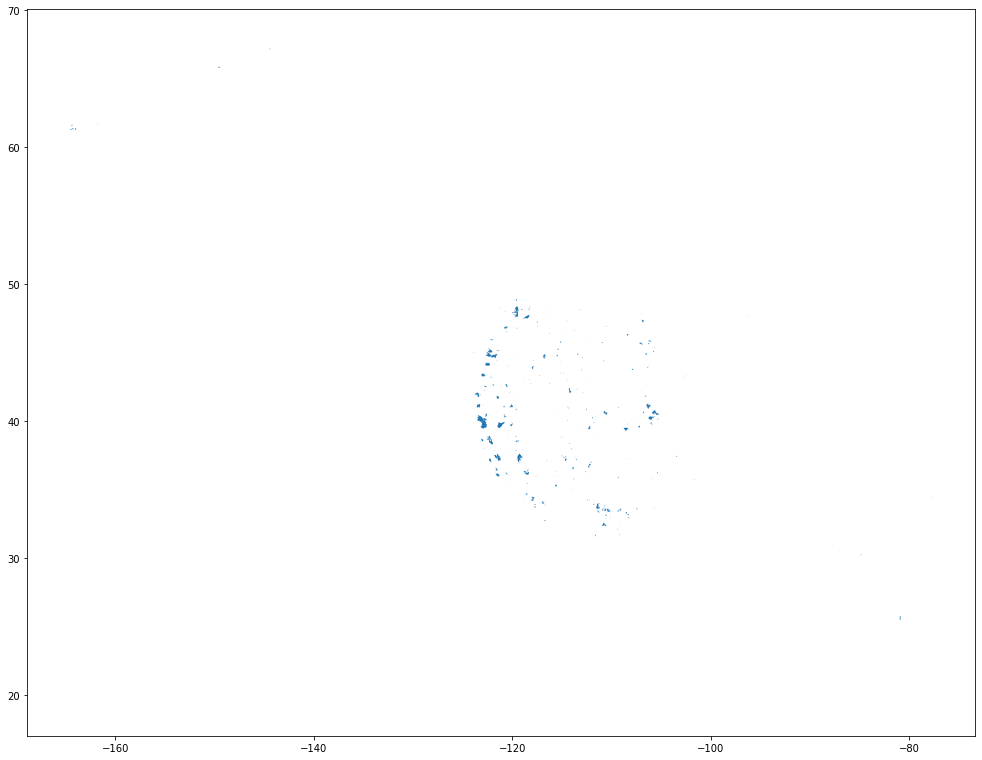

In [24]:
# plot all fires as point data on a map
fires.plot(markersize=1, figsize=(17,17))

In [25]:
pd.set_option('display.max_columns', None)
fires.head()

,OBJECTID,INCIDENT,FIRE_YEAR_,FIRE_YEAR,AGENCY,SOURCE,DATE_CUR,MAP_METHOD,GIS_ACRES,COMMENTS,UNQE_FIRE_,LOCAL_NUM,UNIT_ID,USER_NAME,GEO_ID,SHAPE_Leng,SHAPE_Area,geometry
0,7348,VICS PEAK,2020,2020,USFS,WFDSS,20200714,Infrared,14617.6,None,2020-NMCIF-000223,000223,NMCIF,Molly Wright,4126487,1.812773,0.005747,"MULTIPOLYGON (((-107.45431 33.61050, -107.4542..."
1,7349,Cub,2020,2020,USFS,WFDSS,20200715,Infrared,21494.3,None,2020-NMGNF-000343,000343,NMGNF,Shelly Crook,4100025,1.832110,0.008422,"MULTIPOLYGON (((-108.53574 33.31908, -108.5358..."
2,7350,Bearpaw Mountain,2020,2020,BLM,WFDSS,20200709,Drawn / Satellite,673.4,None,2020-AKTAD-000284,000284,AKTAD,Larry Weddle,4099217,0.215212,0.000498,"POLYGON ((-151.02800 63.89567, -151.02730 63.8..."
3,7351,Wood Springs 2,2020,2020,BIA/Tribal,WFDSS,20200710,Infrared,12864.2,None,2020-AZNAA-000156,000156,AZNAA,Reeve Armstrong,4094911,0.586789,0.005197,"MULTIPOLYGON (((-109.28103 35.96077, -109.2764..."
4,7352,Sheenjek River,2020,2020,BLM,WFDSS,20200709,Drawn / Satellite,3849.9,None,2020-AKUYD-000296,000296,AKUYD,Christopher Moore,4094315,0.521669,0.003228,"POLYGON ((-144.41281 67.21048, -144.41259 67.2..."


In [26]:
fires.columns

Index(['OBJECTID', 'INCIDENT', 'FIRE_YEAR_', 'FIRE_YEAR', 'AGENCY', 'SOURCE',
       'DATE_CUR', 'MAP_METHOD', 'GIS_ACRES', 'COMMENTS', 'UNQE_FIRE_',
       'LOCAL_NUM', 'UNIT_ID', 'USER_NAME', 'GEO_ID', 'SHAPE_Leng',
       'SHAPE_Area', 'geometry'],
      dtype='object')

In [27]:
fires.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [28]:
usa_counties.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [29]:
#from shapely.geometry import mapping

In [30]:
usa_fires_full = gpd.overlay(fires, usa_counties, how='intersection')

In [31]:
usa_fires_full['intersect_area'] = usa_fires_full.geometry.area

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [32]:
usa_fires_full.head()

,OBJECTID,INCIDENT,FIRE_YEAR_,FIRE_YEAR,AGENCY,SOURCE,DATE_CUR,MAP_METHOD,GIS_ACRES,COMMENTS,UNQE_FIRE_,LOCAL_NUM,UNIT_ID,USER_NAME,GEO_ID,SHAPE_Leng,SHAPE_Area,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,intersect_area
0,7348,VICS PEAK,2020,2020,USFS,WFDSS,20200714,Infrared,14617.6,None,2020-NMCIF-000223,000223,NMCIF,Molly Wright,4126487,1.812773,0.005747,35,053,01702371,35053,Socorro,Socorro County,06,H1,G4020,None,None,None,A,17214061650,4843011,+33.9916579,-106.9391362,"MULTIPOLYGON (((-107.45431 33.61050, -107.4542...",0.005747
1,7674,EAST WELL,2020,2020,State,WFDSS,20200823,Drawn / Ground,644.5,Perimeter was digitized by the WFDSS specialis...,2020-NMN3S-000585,000585,NMN3S,Abie Carabajal,4183434,0.091724,0.000255,35,053,01702371,35053,Socorro,Socorro County,06,H1,G4020,None,None,None,A,17214061650,4843011,+33.9916579,-106.9391362,"POLYGON ((-106.26326 34.22377, -106.26409 34.2...",0.000255
2,7349,Cub,2020,2020,USFS,WFDSS,20200715,Infrared,21494.3,None,2020-NMGNF-000343,000343,NMGNF,Shelly Crook,4100025,1.832110,0.008422,35,003,00929108,35003,Catron,Catron County,06,H1,G4020,None,None,None,A,17933559836,14195265,+33.9016208,-108.3919284,"MULTIPOLYGON (((-108.43045 33.31155, -108.4307...",0.008422
3,7401,Good,2020,2020,USFS,WFDSS,20200708,Infrared,17064.9,None,2020-NMGNF-000226,000226,NMGNF,Shelly Crook,4093286,1.808184,0.006676,35,003,00929108,35003,Catron,Catron County,06,H1,G4020,None,None,None,A,17933559836,14195265,+33.9016208,-108.3919284,"MULTIPOLYGON (((-108.36142 33.20107, -108.3616...",0.000548
4,7410,Turkey,2020,2020,USFS,WFDSS,20200613,Infrared,8362.9,None,2020-NMGNF-000227,000227,NMGNF,Shelly Crook,4061710,0.616001,0.003272,35,003,00929108,35003,Catron,Catron County,06,H1,G4020,None,None,None,A,17933559836,14195265,+33.9016208,-108.3919284,"POLYGON ((-108.36142 33.20107, -108.36166 33.2...",0.000380


In [33]:
usa_fires_full['total_area'] = usa_fires_full['ALAND'] + usa_fires_full['AWATER']

In [34]:
usa_fires_full['intersect_area_prop'] = usa_fires_full['intersect_area']/usa_fires_full['total_area']

In [35]:
usa_fires_full['approx_county_acres_burned'] = usa_fires_full['GIS_ACRES'] * usa_fires_full['intersect_area_prop']

In [36]:
usa_fires_full.columns

# 'Event_ID'
# 'irwinID'
# 'Incid_Name' - Name of fire (UNNAMED if not identifiable from source fire occurrence databases).
# 'Incid_Type' - Documented type of fire (WF: Wildfire, Rx: Prescribed Fire; UNK:Unknown).
# 'Map_ID'
# 'Map_Prog' - Mapping program/protocol the fire was mapped with.
# 'Asmnt_Type' - Fire mapping assessment label (Initial (SS) (SS=single scene), Initial, Extended, Extended (SS) (SS=single scene), Emergency, or Emergency (SS)).
# 'BurnBndAc' - Number of acres mapped.
# 'BurnBndLat' - Latitude of the mapped centroid of fire perimeter. 
# 'BurnBndLon' - Longitude of the mapped centroid of fire perimeter. 
# 'Ig_Date' - Date of fire ignition (from source fire occurrence databases).
# 'Pre_ID' - Landsat or Sentinel pre scene ID. 
# 'Post_ID'- Landsat or Sentinel post scene ID. 
# 'Perim_ID' - Landsat or Sentinel perimeter scene ID. Used to help delinate perimeter of an Extended or Extended (SS) assessment. Not always utilized sometimes field will be populated, others not.
# 'dNBR_offst' - The mean dNBR value sampled from an unburned area outside the fire perimeter.  # # 'dNBR_stdDv' - The standard deviation of the mean dNBR value sampled from an unburned area outside the fire perimeter. 
# 'NoData_T' - No data threshold (in dNBR index values; NBR index units for single scene assessments).
# 'IncGreen_T' - Increased greenness threshold (in dNBR index values; NBR index units for single scene assessments).
# 'Low_T' - Unburned/Low threshold (in dNBR index values; NBR index units for single scene assessments). 
# 'Mod_T' - Low/Moderate burn severity threshold (in dNBR index values; NBR index units for single scene assessments).
# 'High_T' - Moderate/High burn severity threshold (in dNBR index values; NBR index units for single scene assessments).
# 'Comment' - As needed comments or notes provided by the mapping analyst to the end user.



# Burn Severity – A qualitative assessment of the heat pulse directed toward the ground during a fire. Burn severity relates to soil heating, large fuel and duff consumption, consumption of the litter and organic layer beneath trees and isolated shrubs, and mortality of buried plant parts.
# Burned Area Boundary – The boundary defining the area burned by a fire. In the context of satellite-based post-fire burn severity mapping, burned areas are typically delineated using remote sensing indices and/or spectral data, and may include unburned “island” areas.
# Differenced Normalized Burn Ratio (dNBR) – A differenced NBR image, or change image, created where the post-fire NBR is subtracted from the pre-fire NBR. The dNBR may be used to discriminate burned from unburned areas and identify vegetation burn severity classes. The dNBR is calculated as: dNBR = NBR pre-fire – NBR post-fire
# Increased Greenness – A discrete burn severity class identified when thresholding dNBR data for Monitoring Trends in Burn Severity assessments. It typically represents areas that burned but display more vegetation cover, density, and/or productivity, usually within one growing season after fire. This is a fire-caused effect from release of nutrients into soil, and/or reduced competition for nutrients, light and water. These areas are usually herbaceous or low shrub communities that undergo little change in species composition after fire.


# High Burn Severity – A discrete burn severity class identified when thresholding dNBR data for Burned Area Emergency Response or Monitoring Trends in Burn Severity assessments, dNDVI for BAER assessments or RdNBR data for Rapid Assessment of Vegetation Condition after Wildfire assessments. In forested ecosystems, it typically represents areas affected by fire where: Substrates, litter is totally consumed; duff is typically nearly entirely consumed; Medium and heavy woody debris are at least partially consumed and at least deeply charred with mostly ash and charcoal remaining; Overstory trees typically exhibit greater than 75 percent mortality; Crown char is typically 100 percent from torching fire, and significant branch loss is present at the highest crown levels. In grassland and shrubland ecosystems, it typically represents areas affected by fire where: Over half of the site exhibits over 50 percent cover of newly exposed mineral soil or rock fragments; Herbaceous plants and shrubs are almost completely charred or consumed above ground, often with notable branch loss on taller shrubs; Resprouting from perennial plants, except grasses, is strongly reduced.

# Low Burn Severity – A discrete burn severity class identified when thresholding dNBR data for Burned Area Emergency Response or Monitoring Trends in Burn Severity assessments, dNDVI for Burned Area Emergency Response assessments or RdNBR data for Rapid Assessment of Vegetation Condition after Wildfire assessments. It includes areas where more than a small proportion of the site burned.  All vegetation strata are slightly altered from the pre-fire state, but some may show pronounced burn effects. In forested ecosystems, it typically represents areas affected by fire where: Substrates, litter often exhibits fairly high consumption (up to 100 percent). Duff, woody debris and newly exposed mineral soil typically exhibit some change. Low vegetation (<1 meter) and shrubs or trees (1-5 meters) may show significant aboveground scorch, char or consumption, and vegetation density or cover may be greatly altered. Intermediate and large overstory trees may exhibit up to 25 percent mortality evidenced by crown char or scorch. Char height from ground flames is typically less than 3 meters.

# Moderate Burn Severity – A discrete burn severity class identified when thresholding dNBR data for Burned Area Emergency Response or Monitoring Trends in Burn Severity (MTBS) assessments, dNDVI for Burned Area Emergency Response assessments or RdNBR data for Rapid Assessment of Vegetation Condition after Wildfire assessments. It includes areas that exhibit conditions that are transitional in magnitude and/or uniformity between characteristics within low and high burn severity classes.

# Normalized Burn Ratio (NBR) – A normalized index that leverages the contrast in response by the near-infrared (NIR) and short-wave infrared (SWIR) bands to leaf area, plant productivity and moisture. Healthy, green vegetation has a high reflection of NIR light and strongly absorbs SWIR light resulting in high NBR values. Increasing damage to vegetation by fire and the exposure of dry, rocky soils results in low NBR values. NBR is calculated for each pre-fire and post-fire scene as: NBR = (NIR - SWIR) ÷ (NIR + SWIR)

# Prescribed Fire – Any fire ignited by management actions to meet specific objectives (NWCG Glossary of Wildland Fire Terminology).

Index(['OBJECTID', 'INCIDENT', 'FIRE_YEAR_', 'FIRE_YEAR', 'AGENCY', 'SOURCE',
       'DATE_CUR', 'MAP_METHOD', 'GIS_ACRES', 'COMMENTS', 'UNQE_FIRE_',
       'LOCAL_NUM', 'UNIT_ID', 'USER_NAME', 'GEO_ID', 'SHAPE_Leng',
       'SHAPE_Area', 'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME',
       'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'intersect_area', 'total_area', 'intersect_area_prop',
       'approx_county_acres_burned'],
      dtype='object')

In [37]:
# create pandas dataframe object with states and fire count
counts_per_county = usa_fires_full.groupby('NAME').size()    
# list highest values first 
#counts_per_county.sort_values(axis=0, ascending=False)

In [38]:
# add values to the original shapefile data as a new field
usa_counties_collapsed= usa_counties.merge(counts_per_county.reset_index(name='number_of_fires'))        
# list first five rows of shapefile
usa_counties_collapsed.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,number_of_fires
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694583,23299110,+39.5769252,-120.5219926,"POLYGON ((-120.65559 39.69356, -120.65552 39.6...",2
1,35,051,01702370,35051,Sierra,Sierra County,06,H1,G4020,None,None,None,A,10829248654,147675972,+33.1194684,-107.1881612,"POLYGON ((-107.24564 33.47797, -107.24013 33.4...",2
2,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,None,None,None,A,1564251834,5285207,+33.2703999,-085.8635254,"POLYGON ((-85.97879 33.32757, -85.97876 33.328...",3
3,48,077,01383824,48077,Clay,Clay County,06,H1,G4020,None,48660,None,A,2819870186,72508536,+33.7859042,-098.2129174,"POLYGON ((-98.42308 33.94453, -98.42308 33.944...",3
4,17,025,00424214,17025,Clay,Clay County,06,H1,G4020,None,None,None,A,1212815740,3271820,+38.7468187,-088.4823254,"POLYGON ((-88.69517 38.82630, -88.69516 38.826...",3


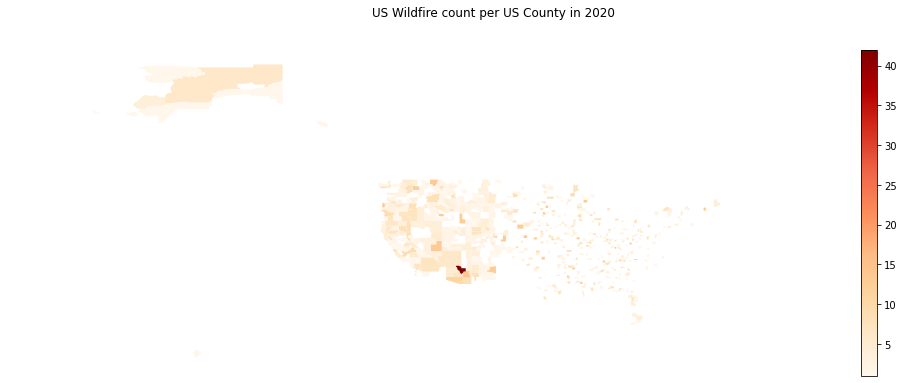

In [39]:
# same map, but without x and y axes and added title
f, ax = plt.subplots(1, figsize=(18,6))
ax = usa_counties_collapsed.plot(column='number_of_fires', cmap='OrRd', legend=True, ax=ax)
lims = plt.axis('equal')
f.suptitle('US Wildfire count per US County in 2020')     
ax.set_axis_off()
plt.show()

In [40]:
usa_fires_full.to_csv('us_fires_full_all_2019.csv', index=False, encoding = "utf_8_sig")

### Bring in CDL Data

In [43]:
full_us_cdl = rxr.open_rasterio("2020_30m_cdls/2020_30m_cdls.tif",
                                 masked=True).squeeze()

In [44]:
full_us_cdl

<xarray.DataArray (y: 96523, x: 153811)>
[14846299153 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 -2.356e+06 -2.356e+06 ... 2.258e+06 2.258e+06
  * y            (y) float64 3.173e+06 3.173e+06 ... 2.77e+05 2.769e+05
    spatial_ref  int64 0
Attributes:
    LAYER_TYPE:                 thematic
    STATISTICS_EXCLUDEDVALUES:  0
    STATISTICS_HISTOBINVALUES:  0|419933303|61528637|14230000|31958866|380270...
    STATISTICS_HISTOMAX:        255
    STATISTICS_HISTOMIN:        0
    STATISTICS_HISTONUMBINS:    256
    STATISTICS_MAXIMUM:         254
    STATISTICS_MEAN:            128.24286184978
    STATISTICS_MEDIAN:          142
    STATISTICS_MINIMUM:         1
    STATISTICS_MODE:            152
    STATISTICS_SKIPFACTORX:     1
    STATISTICS_SKIPFACTORY:     1
    STATISTICS_STDDEV:          56.064771358084
    scale_factor:               1.0
    add_offset:                 0.0
    long_name:                  Layer_1

In [80]:
filepath = "cali_cdl/annual/"  

In [81]:
def load_in(filepath):
    """
    Import and append CDL Layer Data
    """
    
    filelist = glob.glob(filepath + '*.csv')
    list_of_dfs = [pd.read_csv(flist, encoding='utf-8') for flist in
                   filelist]
    df = pd.concat(list_of_dfs, ignore_index=True)
    
    print('Data loaded in: ', len(df), " rows")

    return df

In [82]:
cali_county_cld = load_in(filepath)

Data loaded in:  71227  rows


In [83]:
cali_county_cld.head()

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,1991,YEAR,NaN,COUNTY,CALIFORNIA,6,CENTRAL COAST,40,ALAMEDA,1.0,NaN,NaN,0,NaN,BARLEY,BARLEY - ACRES HARVESTED,TOTAL,NOT SPECIFIED,400,NaN
1,SURVEY,1991,YEAR,NaN,COUNTY,CALIFORNIA,6,CENTRAL COAST,40,ALAMEDA,1.0,NaN,NaN,0,NaN,BARLEY,BARLEY - ACRES PLANTED,TOTAL,NOT SPECIFIED,800,NaN
2,SURVEY,1991,YEAR,NaN,COUNTY,CALIFORNIA,6,CENTRAL COAST,40,ALAMEDA,1.0,NaN,NaN,0,NaN,BARLEY,"BARLEY - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,"17,000",NaN
3,SURVEY,1991,YEAR,NaN,COUNTY,CALIFORNIA,6,CENTRAL COAST,40,ALAMEDA,1.0,NaN,NaN,0,NaN,BARLEY,"BARLEY - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,42.5,NaN
4,SURVEY,1991,YEAR,NaN,COUNTY,CALIFORNIA,6,CENTRAL COAST,40,ALAMEDA,1.0,NaN,NaN,0,NaN,BARLEY,"BARLEY, NON-IRRIGATED - ACRES HARVESTED",TOTAL,NOT SPECIFIED,400,NaN


In [84]:
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace(' - ','_', regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace(', MEASURED IN TONS / ACRE','',regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace(', MEASURED IN BU / NET PLANTED ACRE','',regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace(', MEASURED IN TONS / NET PLANTED ACRE','',regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace(',  MEASURED IN TONS','',regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace(', MEASURED IN LB / NET PLANTED ACRE','',regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace(', MEASURED IN BU / ACRE','',regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace(', MEASURED IN BU','',regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace(', MEASURED IN LB / ACRE','',regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace(', MEASURED IN CWT','',regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace(', MEASURED IN LB','',regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace(', MEASURED IN 480 LB BALES','',regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace(', ','_', regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace('NON-IRRIGATED','NI',regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace('CONTINUOUS CROP','CC',regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace('FOLLOWING SUMMER FALLOW','FSF',regex=True)
cali_county_cld['Data Item'] = cali_county_cld['Data Item'].str.replace(' ','_',regex=True)

In [85]:
cali_county_cld['Data Item'].unique()

array(['BARLEY_ACRES_HARVESTED', 'BARLEY_ACRES_PLANTED',
       'BARLEY_PRODUCTION', 'BARLEY_YIELD', 'BARLEY_NI_ACRES_HARVESTED',
       'BARLEY_NI_ACRES_PLANTED', 'BARLEY_NI_PRODUCTION',
       'BARLEY_NI_YIELD', 'BARLEY_NI_CC_ACRES_HARVESTED',
       'BARLEY_NI_CC_ACRES_PLANTED', 'BARLEY_NI_CC_PRODUCTION',
       'BARLEY_NI_CC_YIELD', 'OATS_ACRES_PLANTED',
       'WHEAT_ACRES_HARVESTED', 'WHEAT_ACRES_PLANTED', 'WHEAT_PRODUCTION',
       'WHEAT_YIELD', 'WHEAT_IRRIGATED_ACRES_HARVESTED',
       'WHEAT_IRRIGATED_ACRES_PLANTED', 'WHEAT_IRRIGATED_PRODUCTION',
       'WHEAT_IRRIGATED_YIELD', 'WHEAT_NI_ACRES_HARVESTED',
       'WHEAT_NI_ACRES_PLANTED', 'WHEAT_NI_PRODUCTION', 'WHEAT_NI_YIELD',
       'WHEAT_NI_CC_ACRES_HARVESTED', 'WHEAT_NI_CC_ACRES_PLANTED',
       'WHEAT_NI_CC_PRODUCTION', 'WHEAT_NI_CC_YIELD',
       'WHEAT_NI_FSF_ACRES_HARVESTED', 'WHEAT_NI_FSF_ACRES_PLANTED',
       'WHEAT_NI_FSF_PRODUCTION', 'WHEAT_NI_FSF_YIELD',
       'WHEAT_WINTER_ACRES_HARVESTED', 'WHEAT_WINTER_ACRE

In [86]:
cali_county_cld.columns

Index(['Program', 'Year', 'Period', 'Week Ending', 'Geo Level', 'State',
       'State ANSI', 'Ag District', 'Ag District Code', 'County',
       'County ANSI', 'Zip Code', 'Region', 'watershed_code', 'Watershed',
       'Commodity', 'Data Item', 'Domain', 'Domain Category', 'Value',
       'CV (%)'],
      dtype='object')

In [87]:
cali_county_cld['row_id'] = cali_county_cld.index

In [88]:
cali_county_cld['Value'] = cali_county_cld['Value'].fillna(0)

In [89]:
cali_county_cld['Value'] = pd.to_numeric(cali_county_cld['Value'].str.replace(',','', regex=True))

In [90]:
cali_county_cld_wide = cali_county_cld.pivot(index=['row_id','Program', 'Year', 'Period', 'Week Ending', 'Geo Level', 'State','State ANSI', 'Ag District', 'Ag District Code', 'County', 'County ANSI', 'Zip Code', 'Region', 'watershed_code', 'Watershed', 'Commodity','Domain', 'Domain Category','CV (%)'], columns='Data Item', values='Value').reset_index()

In [91]:
cali_county_cld_wide.shape

(71227, 192)

In [92]:
cols = cali_county_cld_wide.columns[20:193].tolist()
cali_county_cld_wide[cols] = cali_county_cld_wide[cols].replace({np.nan:0})

In [93]:
cali_county_cld_wide.head()

Data Item,row_id,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Domain,Domain Category,CV (%),BARLEY_ACRES_HARVESTED,BARLEY_ACRES_PLANTED,BARLEY_IRRIGATED_ACRES_HARVESTED,BARLEY_IRRIGATED_ACRES_PLANTED,BARLEY_IRRIGATED_PRODUCTION,BARLEY_IRRIGATED_YIELD,BARLEY_NI_ACRES_HARVESTED,BARLEY_NI_ACRES_PLANTED,BARLEY_NI_CC_ACRES_HARVESTED,BARLEY_NI_CC_ACRES_PLANTED,BARLEY_NI_CC_PRODUCTION,BARLEY_NI_CC_YIELD,BARLEY_NI_FSF_ACRES_HARVESTED,BARLEY_NI_FSF_ACRES_PLANTED,BARLEY_NI_FSF_PRODUCTION,BARLEY_NI_FSF_YIELD,BARLEY_NI_PRODUCTION,BARLEY_NI_YIELD,BARLEY_PRODUCTION,BARLEY_YIELD,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_ACRES_HARVESTED,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_ACRES_PLANTED,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_IRRIGATED_ACRES_HARVESTED,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_IRRIGATED_ACRES_PLANTED,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_IRRIGATED_PRODUCTION,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_IRRIGATED_YIELD,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_PRODUCTION,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_YIELD,BEANS_DRY_EDIBLE_LIMA_ACRES_HARVESTED,BEANS_DRY_EDIBLE_LIMA_ACRES_PLANTED,BEANS_DRY_EDIBLE_LIMA_IRRIGATED_ACRES_HARVESTED,BEANS_DRY_EDIBLE_LIMA_IRRIGATED_ACRES_PLANTED,BEANS_DRY_EDIBLE_LIMA_IRRIGATED_PRODUCTION,BEANS_DRY_EDIBLE_LIMA_IRRIGATED_YIELD,BEANS_DRY_EDIBLE_LIMA_PRODUCTION,BEANS_DRY_EDIBLE_LIMA_YIELD,BEANS_DRY_EDIBLE_OTHER_ACRES_HARVESTED,BEANS_DRY_EDIBLE_OTHER_ACRES_PLANTED,BEANS_DRY_EDIBLE_OTHER_IRRIGATED_ACRES_HARVESTED,BEANS_DRY_EDIBLE_OTHER_IRRIGATED_ACRES_PLANTED,BEANS_DRY_EDIBLE_OTHER_IRRIGATED_PRODUCTION,BEANS_DRY_EDIBLE_OTHER_IRRIGATED_YIELD,BEANS_DRY_EDIBLE_OTHER_PRODUCTION,BEANS_DRY_EDIBLE_OTHER_YIELD,BEANS_DRY_EDIBLE_RED_KIDNEY_ACRES_HARVESTED,BEANS_DRY_EDIBLE_RED_KIDNEY_ACRES_PLANTED,BEANS_DRY_EDIBLE_RED_KIDNEY_IRRIGATED_ACRES_HARVESTED,BEANS_DRY_EDIBLE_RED_KIDNEY_IRRIGATED_ACRES_PLANTED,BEANS_DRY_EDIBLE_RED_KIDNEY_IRRIGATED_PRODUCTION,BEANS_DRY_EDIBLE_RED_KIDNEY_IRRIGATED_YIELD,BEANS_DRY_EDIBLE_RED_KIDNEY_PRODUCTION,BEANS_DRY_EDIBLE_RED_KIDNEY_YIELD,BEANS_DRY_EDIBLE_SMALL_WHITE_ACRES_PLANTED,BEANS_DRY_EDIBLE_SMALL_WHITE_PRODUCTION,BEANS_DRY_EDIBLE_SMALL_WHITE_YIELD,CHICKPEAS_ACRES_HARVESTED,CHICKPEAS_ACRES_PLANTED,CHICKPEAS_IRRIGATED_ACRES_HARVESTED,CHICKPEAS_IRRIGATED_ACRES_PLANTED,CHICKPEAS_IRRIGATED_PRODUCTION,CHICKPEAS_IRRIGATED_YIELD,CHICKPEAS_PRODUCTION,CHICKPEAS_YIELD,CORN_ACRES_PLANTED,CORN_GRAIN_ACRES_HARVESTED,CORN_GRAIN_ACRES_PLANTED_NET,CORN_GRAIN_PRODUCTION,CORN_GRAIN_YIELD,CORN_SILAGE_ACRES_HARVESTED,CORN_SILAGE_PRODUCTION_MEASURED_IN_TONS,CORN_SILAGE_YIELD,COTTON_PIMA_ACRES_HARVESTED,COTTON_PIMA_ACRES_PLANTED,COTTON_PIMA_IRRIGATED_ACRES_HARVESTED,COTTON_PIMA_IRRIGATED_ACRES_PLANTED,COTTON_PIMA_IRRIGATED_PRODUCTION,COTTON_PIMA_IRRIGATED_YIELD,COTTON_PIMA_PRODUCTION,COTTON_PIMA_YIELD,COTTON_UPLAND_ACRES_HARVESTED,COTTON_UPLAND_ACRES_PLANTED,COTTON_UPLAND_IRRIGATED_ACRES_HARVESTED,COTTON_UPLAND_IRRIGATED_ACRES_PLANTED,COTTON_UPLAND_IRRIGATED_PRODUCTION,COTTON_UPLAND_IRRIGATED_YIELD,COTTON_UPLAND_PRODUCTION,COTTON_UPLAND_YIELD,OATS_ACRES_HARVESTED,OATS_ACRES_PLANTED,OATS_IRRIGATED_ACRES_HARVESTED,OATS_IRRIGATED_ACRES_PLANTED,OATS_IRRIGATED_PRODUCTION,OATS_IRRIGATED_YIELD,OATS_NI_ACRES_HARVESTED,OATS_NI_ACRES_PLANTED,OATS_NI_PRODUCTION,OATS_NI_YIELD,OATS_PRODUCTION,OATS_YIELD,RICE_ACRES_HARVESTED,RICE_ACRES_PLANTED,RICE_PRODUCTION,RICE_YIELD,SORGHUM_ACRES_PLANTED,SORGHUM_GRAIN_ACRES_HARVESTED,SORGHUM_GRAIN_PRODUCTION,SORGHUM_GRAIN_YIELD,SUGARBEETS_ACRES_HARVESTED,SUGARBEETS_ACRES_PLANTED,SUGARBEETS_PRODUCTION_MEASURED_IN_TONS,SUGARBEETS_SUCROSE_MEASURED_IN_PCT,SUGARBEETS_YIELD,SUNFLOWER_NON-OIL_TYPE_ACRES_HARVESTED,SUNFLOWER_NON-OIL_TYPE_ACRES_PLANTED,SUNFLOWER_NON-OIL_TYPE_PRODUCTION,SUNFLOWER_NON-OIL_TYPE_YIELD,SUNFLOWER_OIL_TYPE_ACRES_HARVESTED,SUNFLOWER_OIL_TYPE_ACRES_PLANTED,SUNFLOWER_OIL_TYPE_PRODUCTION,SUNFLOWER_OIL_TYPE_YIELD,TOMATOES_IN_THE_OPEN_PROCESSING_ACRES_HARVESTED,TOMATOES_IN_THE_OPEN_PROCESSING_ACRES_PLANTED,TOMATOES_IN_THE_

#### Merge California Cropland Data with Wildfire Data

In [94]:
cali_county_cld_wide['County'] = cali_county_cld_wide['County'].str.capitalize()

In [95]:
cali_fires_full_year_cld = pd.merge(cali_fires_full_year, cali_county_cld_wide, how = 'left', left_on=['NAME', 'Ig_Date_Year'], right_on=['County', 'Year'])

In [96]:
cali_fires_full_year_cld

,NAME,COUNTYFP,COUNTYNS,STATEFP,GEOID,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,total_area,INTPTLAT,INTPTLON,Incid_Type,Ig_Date_Year,Event_ID,BurnBndAc,dNBR_offst,dNBR_stdDv,IncGreen_T,Low_T,Mod_T,High_T,approx_county_acres_burned,intersect_area_prop,row_id,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Domain,Domain Category,CV (%),BARLEY_ACRES_HARVESTED,BARLEY_ACRES_PLANTED,BARLEY_IRRIGATED_ACRES_HARVESTED,BARLEY_IRRIGATED_ACRES_PLANTED,BARLEY_IRRIGATED_PRODUCTION,BARLEY_IRRIGATED_YIELD,BARLEY_NI_ACRES_HARVESTED,BARLEY_NI_ACRES_PLANTED,BARLEY_NI_CC_ACRES_HARVESTED,BARLEY_NI_CC_ACRES_PLANTED,BARLEY_NI_CC_PRODUCTION,BARLEY_NI_CC_YIELD,BARLEY_NI_FSF_ACRES_HARVESTED,BARLEY_NI_FSF_ACRES_PLANTED,BARLEY_NI_FSF_PRODUCTION,BARLEY_NI_FSF_YIELD,BARLEY_NI_PRODUCTION,BARLEY_NI_YIELD,BARLEY_PRODUCTION,BARLEY_YIELD,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_ACRES_HARVESTED,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_ACRES_PLANTED,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_IRRIGATED_ACRES_HARVESTED,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_IRRIGATED_ACRES_PLANTED,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_IRRIGATED_PRODUCTION,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_IRRIGATED_YIELD,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_PRODUCTION,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_YIELD,BEANS_DRY_EDIBLE_LIMA_ACRES_HARVESTED,BEANS_DRY_EDIBLE_LIMA_ACRES_PLANTED,BEANS_DRY_EDIBLE_LIMA_IRRIGATED_ACRES_HARVESTED,BEANS_DRY_EDIBLE_LIMA_IRRIGATED_ACRES_PLANTED,BEANS_DRY_EDIBLE_LIMA_IRRIGATED_PRODUCTION,BEANS_DRY_EDIBLE_LIMA_IRRIGATED_YIELD,BEANS_DRY_EDIBLE_LIMA_PRODUCTION,BEANS_DRY_EDIBLE_LIMA_YIELD,BEANS_DRY_EDIBLE_OTHER_ACRES_HARVESTED,BEANS_DRY_EDIBLE_OTHER_ACRES_PLANTED,BEANS_DRY_EDIBLE_OTHER_IRRIGATED_ACRES_HARVESTED,BEANS_DRY_EDIBLE_OTHER_IRRIGATED_ACRES_PLANTED,BEANS_DRY_EDIBLE_OTHER_IRRIGATED_PRODUCTION,BEANS_DRY_EDIBLE_OTHER_IRRIGATED_YIELD,BEANS_DRY_EDIBLE_OTHER_PRODUCTION,BEANS_DRY_EDIBLE_OTHER_YIELD,BEANS_DRY_EDIBLE_RED_KIDNEY_ACRES_HARVESTED,BEANS_DRY_EDIBLE_RED_KIDNEY_ACRES_PLANTED,BEANS_DRY_EDIBLE_RED_KIDNEY_IRRIGATED_ACRES_HARVESTED,BEANS_DRY_EDIBLE_RED_KIDNEY_IRRIGATED_ACRES_PLANTED,BEANS_DRY_EDIBLE_RED_KIDNEY_IRRIGATED_PRODUCTION,BEANS_DRY_EDIBLE_RED_KIDNEY_IRRIGATED_YIELD,BEANS_DRY_EDIBLE_RED_KIDNEY_PRODUCTION,BEANS_DRY_EDIBLE_RED_KIDNEY_YIELD,BEANS_DRY_EDIBLE_SMALL_WHITE_ACRES_PLANTED,BEANS_DRY_EDIBLE_SMALL_WHITE_PRODUCTION,BEANS_DRY_EDIBLE_SMALL_WHITE_YIELD,CHICKPEAS_ACRES_HARVESTED,CHICKPEAS_ACRES_PLANTED,CHICKPEAS_IRRIGATED_ACRES_HARVESTED,CHICKPEAS_IRRIGATED_ACRES_PLANTED,CHICKPEAS_IRRIGATED_PRODUCTION,CHICKPEAS_IRRIGATED_YIELD,CHICKPEAS_PRODUCTION,CHICKPEAS_YIELD,CORN_ACRES_PLANTED,CORN_GRAIN_ACRES_HARVESTED,CORN_GRAIN_ACRES_PLANTED_NET,CORN_GRAIN_PRODUCTION,CORN_GRAIN_YIELD,CORN_SILAGE_ACRES_HARVESTED,CORN_SILAGE_PRODUCTION_MEASURED_IN_TONS,CORN_SILAGE_YIELD,COTTON_PIMA_ACRES_HARVESTED,COTTON_PIMA_ACRES_PLANTED,COTTON_PIMA_IRRIGATED_ACRES_HARVESTED,COTTON_PIMA_IRRIGATED_ACRES_PLANTED,COTTON_PIMA_IRRIGATED_PRODUCTION,COTTON_PIMA_IRRIGATED_YIELD,COTTON_PIMA_PRODUCTION,COTTON_PIMA_YIELD,COTTON_UPLAND_ACRES_HARVESTED,COTTON_UPLAND_ACRES_PLANTED,COTTON_UPLAND_IRRIGATED_ACRES_HARVESTED,COTTON_UPLAND_IRRIGATED_ACRES_PLANTED,COTTON_UPLAND_IRRIGATED_PRODUCTION,COTTON_UPLAND_IRRIGATED_YIELD,COTTON_UPLAND_PRODUCTION,COTTON_UPLAND_YIELD,OATS_ACRES_HARVESTED,OATS_ACRES_PLANTED,OATS_IRRIGATED_ACRES_HARVESTED,OATS_IRRIGATED_ACRES_PLANTED,OATS_IRRIGATED_PRODUCTION,OATS_IRRIGATED_YIELD,OATS_NI_ACRES_HARVESTED,OATS_NI_ACRES_PLANTED,OATS_NI_PRODUCTION,OATS_NI_YIELD,OATS_PRODUCTION,OATS_YIELD,RICE_ACRES_HARVESTED,RICE_ACRES_PLANTED,RICE_PRODUCTION,RICE_YIELD,SORGHUM_ACRES_PLANTED,SORGHUM_GRAIN_ACRES_HARVESTED,SORGHUM_GRAIN_PRODUCTION,SORGHUM_GRAIN_YIELD,SUGARBEETS_ACRES_HARVESTED,SUGARBEETS_ACRES_PLANTED,SUGARBEETS_PRODUCTION_MEASURED_IN_TONS,SUGARBEETS_SUCROSE_MEASURED_IN_PCT,SUGARBEETS_YIELD,SUNFLOWER_NON-OIL_TYPE_ACRES_HARVESTED,SUNFLOWER_NON-OIL_TYPE_ACRES_PLANTED,SUNFLOWER_NON-OIL_TYPE_PR

In [97]:
cali_fires_full_year_cld.columns.tolist()

['NAME',
 'COUNTYFP',
 'COUNTYNS',
 'STATEFP',
 'GEOID',
 'NAMELSAD',
 'LSAD',
 'CLASSFP',
 'MTFCC',
 'CSAFP',
 'CBSAFP',
 'METDIVFP',
 'FUNCSTAT',
 'ALAND',
 'AWATER',
 'total_area',
 'INTPTLAT',
 'INTPTLON',
 'Incid_Type',
 'Ig_Date_Year',
 'Event_ID',
 'BurnBndAc',
 'dNBR_offst',
 'dNBR_stdDv',
 'IncGreen_T',
 'Low_T',
 'Mod_T',
 'High_T',
 'approx_county_acres_burned',
 'intersect_area_prop',
 'row_id',
 'Program',
 'Year',
 'Period',
 'Week Ending',
 'Geo Level',
 'State',
 'State ANSI',
 'Ag District',
 'Ag District Code',
 'County',
 'County ANSI',
 'Zip Code',
 'Region',
 'watershed_code',
 'Watershed',
 'Commodity',
 'Domain',
 'Domain Category',
 'CV (%)',
 'BARLEY_ACRES_HARVESTED',
 'BARLEY_ACRES_PLANTED',
 'BARLEY_IRRIGATED_ACRES_HARVESTED',
 'BARLEY_IRRIGATED_ACRES_PLANTED',
 'BARLEY_IRRIGATED_PRODUCTION',
 'BARLEY_IRRIGATED_YIELD',
 'BARLEY_NI_ACRES_HARVESTED',
 'BARLEY_NI_ACRES_PLANTED',
 'BARLEY_NI_CC_ACRES_HARVESTED',
 'BARLEY_NI_CC_ACRES_PLANTED',
 'BARLEY_NI_CC_PRODU

In [98]:
cali_fires_full_year_cld.to_csv('calicounty_fires_full_year_aglayer.csv', index=False, encoding = "utf_8_sig")

Convert from Wide to Long

In [99]:
id_vars = ['NAME', 'COUNTYFP', 'COUNTYNS', 'STATEFP', 'GEOID', 'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'total_area', 'INTPTLAT', 'INTPTLON', 'Incid_Type', 'Ig_Date_Year', 'Event_ID', 'BurnBndAc', 'dNBR_offst', 'dNBR_stdDv', 'IncGreen_T', 'Low_T', 'Mod_T', 'High_T', 'approx_county_acres_burned', 'intersect_area_prop', 'row_id', 'Program', 'Year', 'Period', 'Week Ending', 'Geo Level', 'State', 'State ANSI', 'Ag District', 'Ag District Code', 'County', 'County ANSI', 'Zip Code', 'Region', 'watershed_code', 'Watershed', 'Commodity', 'Domain', 'Domain Category', 'CV (%)']

In [100]:
cali_fires_full_year_cld.columns = cali_fires_full_year_cld.columns.str.replace("_PRODUCTION_MEASURED_IN_TONS", ".PRODUCTION")
cali_fires_full_year_cld.columns = cali_fires_full_year_cld.columns.str.replace("_ACRES_PLANTED", ".ACRES_PLANTED")
cali_fires_full_year_cld.columns = cali_fires_full_year_cld.columns.str.replace("_ACRES_HARVESTED", ".ACRES_HARVESTED")
cali_fires_full_year_cld.columns = cali_fires_full_year_cld.columns.str.replace("_PRODUCTION", ".PRODUCTION")
cali_fires_full_year_cld.columns = cali_fires_full_year_cld.columns.str.replace("_YIELD", ".YIELD")


cali_fires_full_year_cld.columns = cali_fires_full_year_cld.columns.str.replace("_MEASURED_IN_PCT", ".PERCENT")
cali_fires_full_year_cld.columns = cali_fires_full_year_cld.columns.str.replace("SUNFLOWER_NON-OIL_TYPE", "SUNFLOWER_NON_OIL_TYPE")



In [101]:
temp = cali_fires_full_year_cld.copy()
temp = temp.rename(columns = lambda df: ".".join(df.split(".")[::-1]))

In [102]:
temp.columns

Index(['NAME', 'COUNTYFP', 'COUNTYNS', 'STATEFP', 'GEOID', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP',
       ...
       'YIELD.WHEAT_WINTER_NI_CC', 'ACRES_HARVESTED.WHEAT_WINTER_NI_FSF',
       'ACRES_PLANTED.WHEAT_WINTER_NI_FSF', 'PRODUCTION.WHEAT_WINTER_NI_FSF',
       'YIELD.WHEAT_WINTER_NI_FSF', 'PRODUCTION.WHEAT_WINTER_NI',
       'YIELD.WHEAT_WINTER_NI', 'PRODUCTION.WHEAT_WINTER',
       'YIELD.WHEAT_WINTER', 'YIELD.WHEAT'],
      dtype='object', length=222)

In [103]:
temp['id'] = temp.index

full_cld_long = pd.wide_to_long(temp, stubnames = ["ACRES_PLANTED", "ACRES_HARVESTED", "PRODUCTION", "YIELD", "ACRES_PLANTED_NET", "PERCENT"], i=id_vars, j="crop", sep='.', suffix=r'\w+')

In [104]:
full_cld_long = full_cld_long.reset_index()  

In [105]:
full_cld_long['crop'] = full_cld_long['crop'].apply(lambda x: x.strip())
full_cld_long['crop'] = full_cld_long['crop'].str.title()
full_cld_long['crop'] = full_cld_long['crop'].str.replace('_',' ',regex=True)

In [106]:
full_cld_long

,NAME,COUNTYFP,COUNTYNS,STATEFP,GEOID,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,total_area,INTPTLAT,INTPTLON,Incid_Type,Ig_Date_Year,Event_ID,BurnBndAc,dNBR_offst,dNBR_stdDv,IncGreen_T,Low_T,Mod_T,High_T,approx_county_acres_burned,intersect_area_prop,row_id,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Domain,Domain Category,CV (%),crop,id,ACRES_PLANTED,ACRES_HARVESTED,PRODUCTION,YIELD,ACRES_PLANTED_NET,PERCENT
0,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Unknown,1992,1,2569,NaN,NaN,NaN,120.0,NaN,NaN,2.519732,0.000981,68261.0,SURVEY,1992.0,YEAR,NaN,COUNTY,CALIFORNIA,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley,0,0.0,200.0,0.0,0.0,NaN,NaN
1,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Unknown,1992,1,2569,NaN,NaN,NaN,120.0,NaN,NaN,2.519732,0.000981,68261.0,SURVEY,1992.0,YEAR,NaN,COUNTY,CALIFORNIA,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Wheat Irrigated,0,0.0,0.0,0.0,0.0,NaN,NaN
2,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Unknown,1992,1,2569,NaN,NaN,NaN,120.0,NaN,NaN,2.519732,0.000981,68261.0,SURVEY,1992.0,YEAR,NaN,COUNTY,CALIFORNIA,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Chickpeas,0,0.0,0.0,0.0,0.0,NaN,NaN
3,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Unknown,1992,1,2569,NaN,NaN,NaN,120.0,NaN,NaN,2.519732,0.000981,68261.0,SURVEY,1992.0,YEAR,NaN,COUNTY,CALIFORNIA,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Wheat Ni,0,0.0,0.0,0.0,0.0,NaN,NaN
4,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Unknown,1992,1,2569,NaN,NaN,NaN,120.0,NaN,NaN,2.519732,0.000981,68261.0,SURVEY,1992.0,YEAR,NaN,COUNTY,CALIFORNIA,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Beans Dry Edible Small White,0,0.0,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516569,Yuba,115,00277322,06,06115,Yuba County,06,H1,G4020,472,49700,NaN,A,1636971148,31000614,1667971762,+39.2662469,-121.3407809,Wildfire,2017,1,16155,-56.0,42.0,-150.0,50.0,313.0,600.0,803.135016,0.049714,28154.0,SURVEY,2017.0,YEAR,NaN,COUNTY,CALIFORNIA,6.0,SACRAMENTO VALLEY,50.0,Yuba,115.0,NaN,NaN,0.0,NaN,RICE,TOTAL,NOT SPECIFIED,NaN,Cotton Pima,32968,0.0,0.0,0.0,0.0,NaN,NaN
1516570,Yuba,115,00277322,06,06115,Yuba County,06,H1,G4020,472,49700,NaN,A,1636971148,31000614,1667971762,+39.2662469,-121.3407809,Wildfire,2017,1,16155,-56.0,42.0,-150.0,50.0,313.0,600.0,803.135016,0.049714,28154.0,SURVEY,2017.0,YEAR,NaN,COUNTY,CALIFORNIA,6.0,SACRAMENTO VALLEY,50.0,Yuba,115.0,NaN,NaN,0.0,NaN,RICE,TOTAL,NOT SPECIFIED,NaN,Barley Ni,32968,0.0,0.0,0.0,0.0,NaN,NaN
1516571,Yuba,115,00277322,06,06115,Yuba County,06,H1,G4020,472,49700,NaN,A,1636971148,31000614,1667971762,+39.2662469,-121.3407809,Wildfire,2017,1,16155,-56.0,42.0,-150.0,50.0,313.0,600.0,803.135016,0.049714,28154.0,SURVEY,2017.0,YEAR,NaN,COUNTY,CALIFORNIA,6.0,SACRAMENTO VALLEY,50.0,Yuba,115.0,NaN,NaN,0.0,NaN,RICE,TOTAL,NOT SPECIFIED,NaN,Beans Dry Edible Other,32968,0.0,0.0,0.0,0.0,NaN,NaN
1516572,Yuba,115,00277322,06,06115,Yuba County,06,H1,G4020,472,49700,NaN,A,1636971148,31000614,1667971762,+39.2662469,-121.3407809,Wildfire,2017,1,16155,-56.0,42.0,-150.0,50.0,313.0,600.0,803.135016,0.049

In [107]:
full_cld_long_clean = full_cld_long[((full_cld_long['ACRES_PLANTED'] > 0) | (full_cld_long['ACRES_HARVESTED'] > 0) | (full_cld_long['PRODUCTION'] > 0) | (full_cld_long['YIELD'] > 0) | (full_cld_long['ACRES_PLANTED_NET'] > 0) | (full_cld_long['PERCENT'] > 0))]

In [108]:
full_cld_long_clean.to_csv('calicounty_fires_full_year_aglayer_long.csv', index=False, encoding = "utf_8_sig")

In [109]:
cali_fires_full_year_cld_wf = cali_fires_full_year_cld[cali_fires_full_year_cld['Incid_Type'] == "Wildfire"]
cali_fires_full_year_cld_wf.head()

,NAME,COUNTYFP,COUNTYNS,STATEFP,GEOID,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,total_area,INTPTLAT,INTPTLON,Incid_Type,Ig_Date_Year,Event_ID,BurnBndAc,dNBR_offst,dNBR_stdDv,IncGreen_T,Low_T,Mod_T,High_T,approx_county_acres_burned,intersect_area_prop,row_id,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Domain,Domain Category,CV (%),BARLEY.ACRES_HARVESTED,BARLEY.ACRES_PLANTED,BARLEY_IRRIGATED.ACRES_HARVESTED,BARLEY_IRRIGATED.ACRES_PLANTED,BARLEY_IRRIGATED.PRODUCTION,BARLEY_IRRIGATED.YIELD,BARLEY_NI.ACRES_HARVESTED,BARLEY_NI.ACRES_PLANTED,BARLEY_NI_CC.ACRES_HARVESTED,BARLEY_NI_CC.ACRES_PLANTED,BARLEY_NI_CC.PRODUCTION,BARLEY_NI_CC.YIELD,BARLEY_NI_FSF.ACRES_HARVESTED,BARLEY_NI_FSF.ACRES_PLANTED,BARLEY_NI_FSF.PRODUCTION,BARLEY_NI_FSF.YIELD,BARLEY_NI.PRODUCTION,BARLEY_NI.YIELD,BARLEY.PRODUCTION,BARLEY.YIELD,BEANS_DRY_EDIBLE_INCL_CHICKPEAS.ACRES_HARVESTED,BEANS_DRY_EDIBLE_INCL_CHICKPEAS.ACRES_PLANTED,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_IRRIGATED.ACRES_HARVESTED,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_IRRIGATED.ACRES_PLANTED,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_IRRIGATED.PRODUCTION,BEANS_DRY_EDIBLE_INCL_CHICKPEAS_IRRIGATED.YIELD,BEANS_DRY_EDIBLE_INCL_CHICKPEAS.PRODUCTION,BEANS_DRY_EDIBLE_INCL_CHICKPEAS.YIELD,BEANS_DRY_EDIBLE_LIMA.ACRES_HARVESTED,BEANS_DRY_EDIBLE_LIMA.ACRES_PLANTED,BEANS_DRY_EDIBLE_LIMA_IRRIGATED.ACRES_HARVESTED,BEANS_DRY_EDIBLE_LIMA_IRRIGATED.ACRES_PLANTED,BEANS_DRY_EDIBLE_LIMA_IRRIGATED.PRODUCTION,BEANS_DRY_EDIBLE_LIMA_IRRIGATED.YIELD,BEANS_DRY_EDIBLE_LIMA.PRODUCTION,BEANS_DRY_EDIBLE_LIMA.YIELD,BEANS_DRY_EDIBLE_OTHER.ACRES_HARVESTED,BEANS_DRY_EDIBLE_OTHER.ACRES_PLANTED,BEANS_DRY_EDIBLE_OTHER_IRRIGATED.ACRES_HARVESTED,BEANS_DRY_EDIBLE_OTHER_IRRIGATED.ACRES_PLANTED,BEANS_DRY_EDIBLE_OTHER_IRRIGATED.PRODUCTION,BEANS_DRY_EDIBLE_OTHER_IRRIGATED.YIELD,BEANS_DRY_EDIBLE_OTHER.PRODUCTION,BEANS_DRY_EDIBLE_OTHER.YIELD,BEANS_DRY_EDIBLE_RED_KIDNEY.ACRES_HARVESTED,BEANS_DRY_EDIBLE_RED_KIDNEY.ACRES_PLANTED,BEANS_DRY_EDIBLE_RED_KIDNEY_IRRIGATED.ACRES_HARVESTED,BEANS_DRY_EDIBLE_RED_KIDNEY_IRRIGATED.ACRES_PLANTED,BEANS_DRY_EDIBLE_RED_KIDNEY_IRRIGATED.PRODUCTION,BEANS_DRY_EDIBLE_RED_KIDNEY_IRRIGATED.YIELD,BEANS_DRY_EDIBLE_RED_KIDNEY.PRODUCTION,BEANS_DRY_EDIBLE_RED_KIDNEY.YIELD,BEANS_DRY_EDIBLE_SMALL_WHITE.ACRES_PLANTED,BEANS_DRY_EDIBLE_SMALL_WHITE.PRODUCTION,BEANS_DRY_EDIBLE_SMALL_WHITE.YIELD,CHICKPEAS.ACRES_HARVESTED,CHICKPEAS.ACRES_PLANTED,CHICKPEAS_IRRIGATED.ACRES_HARVESTED,CHICKPEAS_IRRIGATED.ACRES_PLANTED,CHICKPEAS_IRRIGATED.PRODUCTION,CHICKPEAS_IRRIGATED.YIELD,CHICKPEAS.PRODUCTION,CHICKPEAS.YIELD,CORN.ACRES_PLANTED,CORN_GRAIN.ACRES_HARVESTED,CORN_GRAIN.ACRES_PLANTED_NET,CORN_GRAIN.PRODUCTION,CORN_GRAIN.YIELD,CORN_SILAGE.ACRES_HARVESTED,CORN_SILAGE.PRODUCTION,CORN_SILAGE.YIELD,COTTON_PIMA.ACRES_HARVESTED,COTTON_PIMA.ACRES_PLANTED,COTTON_PIMA_IRRIGATED.ACRES_HARVESTED,COTTON_PIMA_IRRIGATED.ACRES_PLANTED,COTTON_PIMA_IRRIGATED.PRODUCTION,COTTON_PIMA_IRRIGATED.YIELD,COTTON_PIMA.PRODUCTION,COTTON_PIMA.YIELD,COTTON_UPLAND.ACRES_HARVESTED,COTTON_UPLAND.ACRES_PLANTED,COTTON_UPLAND_IRRIGATED.ACRES_HARVESTED,COTTON_UPLAND_IRRIGATED.ACRES_PLANTED,COTTON_UPLAND_IRRIGATED.PRODUCTION,COTTON_UPLAND_IRRIGATED.YIELD,COTTON_UPLAND.PRODUCTION,COTTON_UPLAND.YIELD,OATS.ACRES_HARVESTED,OATS.ACRES_PLANTED,OATS_IRRIGATED.ACRES_HARVESTED,OATS_IRRIGATED.ACRES_PLANTED,OATS_IRRIGATED.PRODUCTION,OATS_IRRIGATED.YIELD,OATS_NI.ACRES_HARVESTED,OATS_NI.ACRES_PLANTED,OATS_NI.PRODUCTION,OATS_NI.YIELD,OATS.PRODUCTION,OATS.YIELD,RICE.ACRES_HARVESTED,RICE.ACRES_PLANTED,RICE.PRODUCTION,RICE.YIELD,SORGHUM.ACRES_PLANTED,SORGHUM_GRAIN.ACRES_HARVESTED,SORGHUM_GRAIN.PRODUCTION,SORGHUM_GRAIN.YIELD,SUGARBEETS.ACRES_HARVESTED,SUGARBEETS.ACRES_PLANTED,SUGARBEETS.PRODUCTION,SUGARBEETS_SUCROSE.PERCENT,SUGARBEETS.YIELD,SUNFLOWER_NON_OIL_TYPE.ACRES_HARVESTED,SUNFLOWER_NON_OIL_TYPE.ACRES_PLANTED,SUNFLOWER_NON_OIL_TYPE.PRODUCTION,SUNFLOWER_NON_OIL_TYPE.YIELD,SUNF

In [110]:
cali_fires_full_year_cld.to_csv('calicounty_fires_full_year_aglayer_wildfireonly.csv', index=False, encoding = "utf_8_sig")

In [111]:
full_cld_long_wf = full_cld_long_clean[full_cld_long_clean['Incid_Type'] == "Wildfire"]
full_cld_long_wf.head()

,NAME,COUNTYFP,COUNTYNS,STATEFP,GEOID,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,total_area,INTPTLAT,INTPTLON,Incid_Type,Ig_Date_Year,Event_ID,BurnBndAc,dNBR_offst,dNBR_stdDv,IncGreen_T,Low_T,Mod_T,High_T,approx_county_acres_burned,intersect_area_prop,row_id,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Domain,Domain Category,CV (%),crop,id,ACRES_PLANTED,ACRES_HARVESTED,PRODUCTION,YIELD,ACRES_PLANTED_NET,PERCENT
7896,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,1986,1,2811,NaN,NaN,NaN,140.0,-457.0,NaN,2.36838,0.000843,16857.0,SURVEY,1986.0,YEAR,NaN,COUNTY,CALIFORNIA,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley,171,0.0,500.0,0.0,0.0,NaN,NaN
7943,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,1986,1,2811,NaN,NaN,NaN,140.0,-457.0,NaN,2.36838,0.000843,16858.0,SURVEY,1986.0,YEAR,NaN,COUNTY,CALIFORNIA,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley,172,1000.0,0.0,0.0,0.0,NaN,NaN
7991,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,1986,1,2811,NaN,NaN,NaN,140.0,-457.0,NaN,2.36838,0.000843,16859.0,SURVEY,1986.0,YEAR,NaN,COUNTY,CALIFORNIA,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley,173,0.0,0.0,29000.0,0.0,NaN,NaN
8032,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,1986,1,2811,NaN,NaN,NaN,140.0,-457.0,NaN,2.36838,0.000843,16860.0,SURVEY,1986.0,YEAR,NaN,COUNTY,CALIFORNIA,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley,174,0.0,0.0,0.0,58.0,NaN,NaN
8078,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,1986,1,2811,NaN,NaN,NaN,140.0,-457.0,NaN,2.36838,0.000843,16861.0,SURVEY,1986.0,YEAR,NaN,COUNTY,CALIFORNIA,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley,175,0.0,0.0,0.0,29.0,NaN,NaN


In [112]:
full_cld_long_wf.to_csv('calicounty_fires_full_year_aglayer_wildfireonly_full.csv', index=False, encoding = "utf_8_sig")

#### Bring in Crop Price Data

In [113]:
import chardet
import pandas as pd

To Clean the File

In [114]:
def clean_ag_prices(filepath, file):
    '''
    '''
    
    with open(filepath + file, 'rb') as f:
        result = chardet.detect(f.read())  # or readline if the file is large
    
    df = pd.read_csv(filepath + file, encoding=result['encoding'], header=[0,2], skiprows = 3)
    
    
    df1 = pd.read_csv(filepath + file, encoding=result['encoding'], on_bad_lines = 'skip')
    
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    
    df.columns = df.columns.str.replace("Value of  production", "Value of production")
    
    if not any(ele in ' '.join(df.columns.tolist()) for ele in ["Value of production", "All Other", "Value of utilized production"]):
        df = pd.read_csv(filepath + file, encoding=result['encoding'], header=[0,2], skiprows = 4)
    
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
        
        if not any(ele in ' '.join(df.columns.tolist()) for ele in ["Value of production", "All Other", "Value of utilized production"]):
            df = pd.read_csv(filepath + file, encoding=result['encoding'], header=[0,1,3], skiprows = 4)      
            df.columns = ['_'.join(col).strip() for col in df.columns.values]

            df.columns = df.columns.str.replace("Price per_Bushel", "Price per bushel")
            df.columns = df.columns.str.replace("Price per_Cwt", "Price per cwt")
            df.columns = df.columns.str.replace("Price per_Ton", "Price per ton")
            df.columns = df.columns.str.replace("Price per_Pound", "Price per pound")
            df.columns = df.columns.str.replace("Price per_Gallon", "Price per gallon")
            df.columns = df.columns.str.replace("Price_Per Pound", "Price per pound")
            df.columns = df.columns.str.replace("Value of_Production", "Value of production")
            df.columns = df.columns.str.replace("Value of production ", "Value of production")
        else:
            df = df.copy()
        
    elif '20' not in ' '.join(df.columns.tolist()):
        df = pd.read_csv(filepath + file, encoding=result['encoding'], header=[0,3], skiprows = 3)
    
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    else: 
        df = df.copy()
    
    df['id'] = df.index
    
    df = df.iloc[:, 2:]
    
    df.columns = df.columns.str.replace(" 1/", "")
    df.columns = df.columns.str.replace(" 2/", "")
    df.columns = df.columns.str.replace(" 3/", "")
    df.columns = df.columns.str.replace("1/", "")
    df.columns = df.columns.str.replace("2/", "")
    df.columns = df.columns.str.replace("3/", "")
    
    try:
        if "Bushel" in df1.iloc[0,2].rsplit(" Price")[1]:
            df = pd.wide_to_long(df, ["Price per bushel", "Value of production"], i="id", j="year", sep='_')
        elif "Ton" in df1.iloc[0,2].rsplit(" Price")[1]:
            df = pd.wide_to_long(df, ["Price per ton", "Value of production"], i="id", j="year", sep='_')
        elif "Pound" in df1.iloc[0,2].rsplit(" Price")[1]:
            df = pd.wide_to_long(df, ["Price per pound", "Value of production"], i="id", j="year", sep='_')
        elif (("Cwt" in df1.iloc[0,2].rsplit(" Price")[1]) & ('utilized production' not in ' '.join(df.columns.tolist()))):
            df = pd.wide_to_long(df, ["Price per cwt", "Value of production"], i="id", j="year", sep='_')
        elif 'utilized production' in ' '.join(df.columns.tolist()):
            df = pd.wide_to_long(df, ["Price per cwt", "Value of utilized production"], i="id", j="year", sep='_')
        else:
            df = pd.wide_to_long(df, ["Price per gallon", "Value of production"], i="id", j="year", sep='_')
    except:
        if "Alfalfa" in df1.iloc[0,2].rsplit(" Price")[0]:
            df = pd.wide_to_long(df, ["Alfalfa", "All Other"], i="id", j="year", sep='_')
        else:
            df = pd.wide_to_long(df, ["Value of production"], i="id", j="year", sep='_')
            
        
    df = df.reset_index()
    
    df = df.rename(columns={'Unnamed: 2_level_0_Unnamed: 2_level_1': 'State'})
    
    if "State" not in df.columns.to_list():
        df = df.rename(columns={'Unnamed: 2_level_0_Unnamed: 2_level_1_Unnamed: 2_level_2': 'State'})
    else:
        df = df.copy()
    
    states = pd.read_csv("name-abbr.csv", header = None)
    
    df['State'] = df['State'].astype(str)
    df['State'] = df['State'].apply(lambda x: x.strip())
    
    df_st = pd.merge(df, states, how = 'left', left_on=['State'], right_on=0)

    df_st = df_st[df_st[0].notna()]

    df_st = df_st.drop([0, 1], axis=1)

    if len(df_st) == 0:
        df_st = pd.merge(df, states, how = 'left', left_on=['State'], right_on=1)

        df_st = df_st[df_st[1].notna()]

        df_st = df_st.drop(["State"], axis=1)
        df_st = df_st.rename(columns={0: 'State'})
        df_st = df_st.drop([1], axis=1)

    else:
        df_st = df_st.copy()
    
    df_st['Crop'] = df1.iloc[0,2].rsplit(" Price")[0]
    df_st['Crop'] = df_st['Crop'].str.replace('[^\w\s]','', regex=True)
    
    df_st['Crop'] = df_st['Crop'].apply(lambda x: x.strip())
    
    df_st['Crop'] = df_st['Crop'].str.replace('All ','',regex=True)

    df_st['Crop'] = df_st['Crop'].str.replace('Chickpea','Chickpeas',regex=True)
    
    df_st['Crop'] = df_st['Crop'].str.replace('Oats','Oat',regex=True)

    df_st['Crop'] = df_st['Crop'].str.replace('Oat','Oats',regex=True)
    
    df_st['Crop'] = df_st['Crop'].str.replace('Peanuts','Peanut',regex=True)

    df_st['Crop'] = df_st['Crop'].str.replace('Peanut','Peanuts',regex=True)

    df_st['Crop'] = df_st['Crop'].str.replace('Cottonseed','Cotton',regex=True)
    
    df_st['Crop'] = df_st['Crop'].str.replace('Corn for Grain','Corn Grain',regex=True)
    
    return df_st

In [115]:
filepath = "crop_prices/CropValuSu-02-19-2010/"
file = "cpvl_019.csv"

In [116]:
clean_ag_prices(filepath, file)
#"cpvl_p41a_t041.csv" - Value of utilized production

,id,year,State,Price per cwt,Value of production,Crop
2,2,2007,Arkansas,12.10,1159349,Rice
3,3,2007,California,16.20,707681,Rice
4,4,2007,Louisiana,12.70,294919,Rice
5,5,2007,Mississippi,12.60,175039,Rice
6,6,2007,Missouri,11.90,146120,Rice
7,7,2007,Texas,12.40,117763,Rice
13,2,2008,Arkansas,15.00,1394070,Rice
14,3,2008,California,27.50,1183325,Rice
15,4,2008,Louisiana,15.40,416370,Rice
16,5,2008,Mississippi,15.40,241580,Rice


To bring in for the year

In [117]:
directory = "crop_prices/"

In [118]:
def annual_prices(filepath): 

    """
    Import. 
    """
    filepath = filepath + "/"
    filelist = glob.glob(filepath + '*_index.htm')
    if len(filelist) == 0:
        filelist = glob.glob(filepath + '*indxcpvl.htm')
    else:
        filelist = filelist
    check = pd.read_html(filelist[0], skiprows = 1, header=0, flavor='html5lib')[0]
    check = check.loc[check['Table Description'].str.contains('Production – States and United States')]
    file_full = check['File Name'].tolist()
    if len(file_full) == 0:
        check = pd.read_html(filelist[0], skiprows = 1, header=0, flavor='html5lib')[0]
        check = check.loc[check['Table Description'].str.contains('Production, by State and United States')]
        file_full = check['File Name'].tolist()
        
        if len(file_full) == 0:
            check = pd.read_html(filelist[0], skiprows = 1, header=0, flavor='html5lib')[0]
            check = check.loc[check['Table Description'].str.contains('Production `- States and United States')]
            file_full = check['File Name'].tolist()
        else:
            file_fill = file_full
    else: 
        file_full = file_full

    list_of_dfs = [clean_ag_prices(filepath,file) for file in
                   file_full]
    df = pd.concat(list_of_dfs, ignore_index=True)

    print('Data loaded in: ', len(df), " rows")

    return df

In [119]:
annual_df = annual_prices(filepath)

Data loaded in:  1545  rows


In [120]:
annual_df.head()

,id,year,State,Price per bushel,Value of production,Crop,Price per cwt,Price per pound,Price per ton,Price per gallon
0,2,2007,Alabama,4.54,99154,Corn Grain,NaN,NaN,NaN,NaN
1,3,2007,Arizona,5.03,20472,Corn Grain,NaN,NaN,NaN,NaN
2,4,2007,Arkansas,3.80,378898,Corn Grain,NaN,NaN,NaN,NaN
3,5,2007,California,4.28,148002,Corn Grain,NaN,NaN,NaN,NaN
4,6,2007,Colorado,3.96,587664,Corn Grain,NaN,NaN,NaN,NaN


To bring in for all the years

In [121]:
def full_prices(directory): 

    """
    Import. 
    """
    
    all_filepath = [x[0] for x in os.walk(directory)][1:]
    
    all_dfs = [annual_prices(filee) for filee in
                   all_filepath]
    
    df_new = pd.concat(all_dfs, ignore_index=True)
    
    df_new = df_new.drop_duplicates(keep='first')
    
    df_new_long = df_new.melt(id_vars=["id", "year", "State", "Crop"], value_vars=["Price per bushel","Value of production","Price per cwt","Price per pound","Price per ton","Alfalfa","All Other","Value of utilized production","Price per gallon"], var_name="Variable", value_name='Value', ignore_index=True)
    
    df_new_long = df_new_long.sort_values('Value', ascending=False).drop_duplicates(subset=['year', 'State',"Crop"], keep='first')
    
    df_new_wide = df_new_long.pivot(index=['id','year','State','Crop'], columns='Variable', values='Value').reset_index()

    print('Data loaded in: ', len(df_new_wide), " rows")
    #28860

    return df_new_wide

In [122]:
full_crop_price_df = full_prices(directory)

Data loaded in:  1603  rows
Data loaded in:  1638  rows
Data loaded in:  1612  rows
Data loaded in:  1596  rows
Data loaded in:  1552  rows
Data loaded in:  1594  rows
Data loaded in:  1596  rows
Data loaded in:  1649  rows
Data loaded in:  1599  rows
Data loaded in:  1652  rows
Data loaded in:  1652  rows
Data loaded in:  1652  rows
Data loaded in:  1553  rows
Data loaded in:  1553  rows
Data loaded in:  1632  rows
Data loaded in:  1553  rows
Data loaded in:  1545  rows
Data loaded in:  1629  rows
Data loaded in:  12413  rows


In [123]:
full_crop_price_df.head()

Variable,id,year,State,Crop,Alfalfa,All Other,Price per bushel,Price per cwt,Price per gallon,Price per pound,Price per ton,Value of production,Value of utilized production
0,2,1999,Alabama,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46556,NaN
1,2,1999,Alabama,Cotton,NaN,NaN,NaN,NaN,NaN,NaN,79.00,NaN,NaN
2,2,1999,Alabama,Hay,NaN,NaN,NaN,NaN,NaN,NaN,55.00,NaN,NaN
3,2,1999,Alabama,Other Hay,NaN,NaN,NaN,NaN,NaN,NaN,55.00,NaN,NaN
4,2,1999,Alabama,Peanuts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120077,NaN


Merge CDL, WF, and Crop Price Data 

In [124]:
full_cld_long_clean['State'] = "California"

/var/folders/tv/c561t29x6496yycsl2cv_z9h0000gn/T/ipykernel_2484/1887012379.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_cld_long_clean['State'] = "California"


In [125]:
full_cld_long_clean.head()

,NAME,COUNTYFP,COUNTYNS,STATEFP,GEOID,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,total_area,INTPTLAT,INTPTLON,Incid_Type,Ig_Date_Year,Event_ID,BurnBndAc,dNBR_offst,dNBR_stdDv,IncGreen_T,Low_T,Mod_T,High_T,approx_county_acres_burned,intersect_area_prop,row_id,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Domain,Domain Category,CV (%),crop,id,ACRES_PLANTED,ACRES_HARVESTED,PRODUCTION,YIELD,ACRES_PLANTED_NET,PERCENT
0,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Unknown,1992,1,2569,NaN,NaN,NaN,120.0,NaN,NaN,2.519732,0.000981,68261.0,SURVEY,1992.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley,0,0.0,200.0,0.0,0.0,NaN,NaN
85,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Unknown,1992,1,2569,NaN,NaN,NaN,120.0,NaN,NaN,2.519732,0.000981,68262.0,SURVEY,1992.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley,1,300.0,0.0,0.0,0.0,NaN,NaN
131,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Unknown,1992,1,2569,NaN,NaN,NaN,120.0,NaN,NaN,2.519732,0.000981,68263.0,SURVEY,1992.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley,2,0.0,0.0,10000.0,0.0,NaN,NaN
177,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Unknown,1992,1,2569,NaN,NaN,NaN,120.0,NaN,NaN,2.519732,0.000981,68264.0,SURVEY,1992.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley,3,0.0,0.0,0.0,50.0,NaN,NaN
229,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Unknown,1992,1,2569,NaN,NaN,NaN,120.0,NaN,NaN,2.519732,0.000981,68265.0,SURVEY,1992.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley Ni,4,0.0,200.0,0.0,0.0,NaN,NaN


In [126]:
full_cld_long_clean['crop'].unique()

array(['Barley', 'Barley Ni', 'Barley Ni Cc', 'Oats', 'Wheat', 'Wheat Ni',
       'Wheat Ni Cc', 'Wheat Ni Fsf', 'Wheat Winter', 'Wheat Winter Ni',
       'Wheat Winter Ni Cc', 'Wheat Winter Ni Fsf', 'Corn', 'Corn Grain',
       'Barley Ni Fsf', 'Wheat Irrigated', 'Wheat Winter Irrigated',
       'Barley Irrigated', 'Oats Ni', 'Corn Silage',
       'Beans Dry Edible Incl Chickpeas',
       'Beans Dry Edible Incl Chickpeas Irrigated',
       'Beans Dry Edible Lima', 'Beans Dry Edible Lima Irrigated',
       'Beans Dry Edible Red Kidney',
       'Beans Dry Edible Red Kidney Irrigated', 'Rice', 'Sugarbeets',
       'Sugarbeets Sucrose', 'Sorghum', 'Sorghum Grain',
       'Beans Dry Edible Other', 'Wheat Spring Durum',
       'Wheat Spring Durum Irrigated', 'Beans Dry Edible Other Irrigated',
       'Tomatoes In The Open Processing', 'Cotton Upland',
       'Sunflower Oil Type', 'Chickpeas', 'Chickpeas Irrigated',
       'Cotton Pima', 'Cotton Upland Irrigated', 'Cotton Pima Irrigated',
  

In [127]:
full_crop_price_df['Crop'].unique()

array(['Corn Grain', 'Cotton', 'Hay', 'Other Hay', 'Peanuts', 'Potatoes',
       'Sorghum for Grain', 'Soybeans for Beans', 'Sweet Potatoes',
       'Wheat', 'Winter Wheat', 'Alfalfa Hay', 'Barley', 'Durum Wheat',
       'Rice', 'Dry Edible Beans', 'Sugarbeets', 'Other Spring Wheat',
       'Proso Millet', 'Maple Syrup', 'Austrian Winter Peas',
       'Dry Edible Peas', 'Hops', 'Lentils', 'Wrinkled Seed Peas',
       'Canola', 'Flaxseed', 'Oats', 'Rye', 'Safflower',
       'Soybean for Beans', 'Sweet Potato', 'Sugarbeet',
       'Austrian Winter Pea', 'Dry Edible Pea', 'Lentil',
       'Wrinkled Seed Pea', 'Tobacco', 'Dry Edible Bean',
       'Forage Value of Production  States and United States 20102012',
       'Forage Value of Production  States and United States 20112013',
       'Forage Value of Production  States and United States 20122014',
       'Forage Value of Production  States and United States 20132015',
       'Forage Value of Production  States and United States 2014201

In [176]:
final_wf_ag_pric = pd.merge(full_cld_long_clean, full_crop_price_df, how = 'left', left_on=['State','Ig_Date_Year','crop'], right_on=['State', "year","Crop"])

In [177]:
final_wf_ag_pric.head()

,NAME,COUNTYFP,COUNTYNS,STATEFP,GEOID,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,total_area,INTPTLAT,INTPTLON,Incid_Type,Ig_Date_Year,Event_ID,BurnBndAc,dNBR_offst,dNBR_stdDv,IncGreen_T,Low_T,Mod_T,High_T,approx_county_acres_burned,intersect_area_prop,row_id,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Domain,Domain Category,CV (%),crop,id_x,ACRES_PLANTED,ACRES_HARVESTED,PRODUCTION,YIELD,ACRES_PLANTED_NET,PERCENT,id_y,year,Crop,Alfalfa,All Other,Price per bushel,Price per cwt,Price per gallon,Price per pound,Price per ton,Value of production,Value of utilized production
0,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Unknown,1992,1,2569,NaN,NaN,NaN,120.0,NaN,NaN,2.519732,0.000981,68261.0,SURVEY,1992.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley,0,0.0,200.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Unknown,1992,1,2569,NaN,NaN,NaN,120.0,NaN,NaN,2.519732,0.000981,68262.0,SURVEY,1992.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley,1,300.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Unknown,1992,1,2569,NaN,NaN,NaN,120.0,NaN,NaN,2.519732,0.000981,68263.0,SURVEY,1992.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley,2,0.0,0.0,10000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Unknown,1992,1,2569,NaN,NaN,NaN,120.0,NaN,NaN,2.519732,0.000981,68264.0,SURVEY,1992.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley,3,0.0,0.0,0.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Unknown,1992,1,2569,NaN,NaN,NaN,120.0,NaN,NaN,2.519732,0.000981,68265.0,SURVEY,1992.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,BARLEY,TOTAL,NOT SPECIFIED,NaN,Barley Ni,4,0.0,200.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
final_wf_ag_pric = final_wf_ag_pric[final_wf_ag_pric['id_y'].notna()]

In [179]:
final_wf_ag_pric = final_wf_ag_pric.drop(['id_x','id_y'], axis=1)

In [180]:
final_wf_ag_pric.head()

,NAME,COUNTYFP,COUNTYNS,STATEFP,GEOID,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,total_area,INTPTLAT,INTPTLON,Incid_Type,Ig_Date_Year,Event_ID,BurnBndAc,dNBR_offst,dNBR_stdDv,IncGreen_T,Low_T,Mod_T,High_T,approx_county_acres_burned,intersect_area_prop,row_id,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Domain,Domain Category,CV (%),crop,ACRES_PLANTED,ACRES_HARVESTED,PRODUCTION,YIELD,ACRES_PLANTED_NET,PERCENT,year,Crop,Alfalfa,All Other,Price per bushel,Price per cwt,Price per gallon,Price per pound,Price per ton,Value of production,Value of utilized production
332,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39317.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,400.0,0.0,0.0,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN
333,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39318.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,0.0,61000.0,0.0,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN
334,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39319.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,0.0,0.0,152.5,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN
335,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39320.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,OATS,TOTAL,NOT SPECIFIED,NaN,Oats,700.0,0.0,0.0,0.0,NaN,NaN,2003.0,Oats,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5600,NaN
336,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39322.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,WHEAT,TOTAL,NOT SPECIFIED,NaN,Wheat,0.0,1000.0,0.0,0.0,NaN,NaN,2003.0,Wheat,NaN,NaN,3.54,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
def price_calc(row):
    if row['Alfalfa'] != np.nan:
        return row['Alfalfa']
    elif row['All Other'] != np.nan:
        return row['All Other'] 
    elif row['Price per bushel'] != np.nan:
         return row['Price per bushel'] 
    elif row['Price per cwt'] != np.nan:
        return row['Price per cwt'] 
    elif row['Price per gallon'] != np.nan:
        return row['Price per gallon'] 
    elif row['Price per pound'] != np.nan:
        return row['Price per pound'] 
    elif row['Price per ton'] != np.nan: 
        return row['Price per ton']
    else:
        return np.nan

In [182]:
final_wf_ag_pric['Price'] = final_wf_ag_pric[['Alfalfa', 'All Other', 'Price per bushel', 'Price per cwt', 'Price per gallon', 'Price per pound', 'Price per ton']].fillna(method='bfill', axis=1).iloc[:, 0]

In [183]:
final_wf_ag_pric.head()

,NAME,COUNTYFP,COUNTYNS,STATEFP,GEOID,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,total_area,INTPTLAT,INTPTLON,Incid_Type,Ig_Date_Year,Event_ID,BurnBndAc,dNBR_offst,dNBR_stdDv,IncGreen_T,Low_T,Mod_T,High_T,approx_county_acres_burned,intersect_area_prop,row_id,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Domain,Domain Category,CV (%),crop,ACRES_PLANTED,ACRES_HARVESTED,PRODUCTION,YIELD,ACRES_PLANTED_NET,PERCENT,year,Crop,Alfalfa,All Other,Price per bushel,Price per cwt,Price per gallon,Price per pound,Price per ton,Value of production,Value of utilized production,Price
332,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39317.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,400.0,0.0,0.0,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN,NaN
333,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39318.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,0.0,61000.0,0.0,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN,NaN
334,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39319.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,0.0,0.0,152.5,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN,NaN
335,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39320.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,OATS,TOTAL,NOT SPECIFIED,NaN,Oats,700.0,0.0,0.0,0.0,NaN,NaN,2003.0,Oats,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5600,NaN,NaN
336,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39322.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,WHEAT,TOTAL,NOT SPECIFIED,NaN,Wheat,0.0,1000.0,0.0,0.0,NaN,NaN,2003.0,Wheat,NaN,NaN,3.54,NaN,NaN,NaN,NaN,NaN,NaN,3.54


In [184]:
final_wf_ag_pric[final_wf_ag_pric['Price per ton'].notna()]

,NAME,COUNTYFP,COUNTYNS,STATEFP,GEOID,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,total_area,INTPTLAT,INTPTLON,Incid_Type,Ig_Date_Year,Event_ID,BurnBndAc,dNBR_offst,dNBR_stdDv,IncGreen_T,Low_T,Mod_T,High_T,approx_county_acres_burned,intersect_area_prop,row_id,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Domain,Domain Category,CV (%),crop,ACRES_PLANTED,ACRES_HARVESTED,PRODUCTION,YIELD,ACRES_PLANTED_NET,PERCENT,year,Crop,Alfalfa,All Other,Price per bushel,Price per cwt,Price per gallon,Price per pound,Price per ton,Value of production,Value of utilized production,Price
1416,Butte,007,01675842,06,06007,Butte County,06,H1,G4020,NaN,17020,NaN,A,4238423343,105325812,4343749155,+39.6659588,-121.6019188,Wildfire,1999,7,70805,32.000000,30.0,-150.0,130.00,340.000000,595.0,149.609348,0.009687,49003.0,SURVEY,1999.0,YEAR,NaN,COUNTY,California,6.0,SACRAMENTO VALLEY,50.0,Butte,7.0,NaN,NaN,0.0,NaN,SUGARBEETS,TOTAL,NOT SPECIFIED,NaN,Sugarbeets,0.0,500.0,0.0,0.0,NaN,NaN,1999.0,Sugarbeets,NaN,NaN,NaN,NaN,NaN,NaN,36.80,NaN,NaN,36.80
1417,Butte,007,01675842,06,06007,Butte County,06,H1,G4020,NaN,17020,NaN,A,4238423343,105325812,4343749155,+39.6659588,-121.6019188,Wildfire,1999,7,70805,32.000000,30.0,-150.0,130.00,340.000000,595.0,149.609348,0.009687,49004.0,SURVEY,1999.0,YEAR,NaN,COUNTY,California,6.0,SACRAMENTO VALLEY,50.0,Butte,7.0,NaN,NaN,0.0,NaN,SUGARBEETS,TOTAL,NOT SPECIFIED,NaN,Sugarbeets,500.0,0.0,0.0,0.0,NaN,NaN,1999.0,Sugarbeets,NaN,NaN,NaN,NaN,NaN,NaN,36.80,NaN,NaN,36.80
1418,Butte,007,01675842,06,06007,Butte County,06,H1,G4020,NaN,17020,NaN,A,4238423343,105325812,4343749155,+39.6659588,-121.6019188,Wildfire,1999,7,70805,32.000000,30.0,-150.0,130.00,340.000000,595.0,149.609348,0.009687,49005.0,SURVEY,1999.0,YEAR,NaN,COUNTY,California,6.0,SACRAMENTO VALLEY,50.0,Butte,7.0,NaN,NaN,0.0,NaN,SUGARBEETS,TOTAL,NOT SPECIFIED,NaN,Sugarbeets,0.0,0.0,19000.0,0.0,NaN,NaN,1999.0,Sugarbeets,NaN,NaN,NaN,NaN,NaN,NaN,36.80,NaN,NaN,36.80
1420,Butte,007,01675842,06,06007,Butte County,06,H1,G4020,NaN,17020,NaN,A,4238423343,105325812,4343749155,+39.6659588,-121.6019188,Wildfire,1999,7,70805,32.000000,30.0,-150.0,130.00,340.000000,595.0,149.609348,0.009687,49007.0,SURVEY,1999.0,YEAR,NaN,COUNTY,California,6.0,SACRAMENTO VALLEY,50.0,Butte,7.0,NaN,NaN,0.0,NaN,SUGARBEETS,TOTAL,NOT SPECIFIED,NaN,Sugarbeets,0.0,0.0,0.0,38.0,NaN,NaN,1999.0,Sugarbeets,NaN,NaN,NaN,NaN,NaN,NaN,36.80,NaN,NaN,36.80
2715,Colusa,011,01675902,06,06011,Colusa County,06,H1,G4020,NaN,NaN,NaN,A,2980372757,14581043,2994953800,+39.1777385,-122.2375629,Wildfire,1999,1,37162,8.000000,NaN,-150.0,130.00,294.000000,510.0,248.414843,0.006685,49099.0,SURVEY,1999.0,YEAR,NaN,COUNTY,California,6.0,SACRAMENTO VALLEY,50.0,Colusa,11.0,NaN,NaN,0.0,NaN,SUGARBEETS,TOTAL,NOT SPECIFIED,NaN,Sugarbeets,0.0,1600.0,0.0,0.0,NaN,NaN,1999.0,Sugarbeets,NaN,NaN,NaN,NaN,NaN,NaN,36.80,NaN,NaN,36.80
2716,Colusa,011,01675902,06,06011,Colusa County,06,H1,G4020,NaN,NaN,NaN,A,2980372757,14581043,2994953800,+39.1777385,-122.2375629,Wildfire,1999,1,37162,8.000000,NaN,-150.0,130.00,294.000000,510.0,248.414843,0.006685,49100.0,SURVEY,1999.0,YEAR,NaN,COUNTY,California,6.0,SACRAMENTO VALLEY,50.0,Colusa,11.0,NaN,NaN,0.0,NaN,SUGARBEETS,TOTAL,NOT SPECIFIED,NaN,Sugarbeets,1600.0,0.0,0.0,0.0,NaN,NaN,1999.0,Sugarbeets,NaN,NaN,NaN,NaN,NaN,NaN,36.80,NaN,NaN,36.80
2717,Colusa,011,01675902,06,06011,Colusa County,06,H1,G4020,NaN,NaN,NaN,A,2980372757,14581043,2994953800,+39.1777385,-122.2375629,Wildfire,1999,1,37162,8.000000,NaN,-150.0,130.00,294.000000,510.0,248.414843,0.006685,49101.0,SURVEY,1999.0,YEAR,NaN,COUNTY,California,6.0,SACRAMENTO VALLEY,50.0,Colusa,11.0,NaN,NaN,0.0,NaN,SUGARBEETS,TOTAL,NOT SPECIFIED,NaN,Sugarbeets,0.0,0.0,48000.0,0.0,NaN,NaN,1999.0,Sugarbeets,NaN,NaN,NaN,NaN,NaN,NaN,36.80,NaN,NaN,36.80
2719,Colusa,011,01675902,06,06011,Colusa County,06,H1,G4020,NaN,NaN,NaN,A,2980372757,14581043,2994

Explore Agricultural Data 

In [185]:
def ag_diff(var, df):
    county_only_df = df[['Ig_Date_Year', 'State','NAME','crop', var]].sort_values(['Ig_Date_Year', 'State','NAME','crop',var], ascending = False).drop_duplicates(keep = "first")
    
    county_only_df.sort_values(['Ig_Date_Year', 'State','NAME','crop'], inplace=True)
    county_only_df['diff'] = county_only_df[var].diff()
    
    county_only_df.columns = county_only_df.columns.str.replace("diff", var + "_diff")
    
    return county_only_df

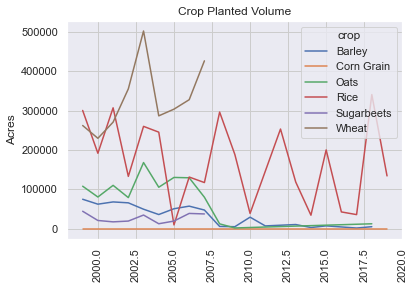

In [186]:
planted = ag_diff("ACRES_PLANTED", final_wf_ag_pric)

plant_cali = planted.groupby(by=["State", "Ig_Date_Year", "crop"], dropna=False, as_index=False).agg({'ACRES_PLANTED':'sum', 'ACRES_PLANTED_diff':'mean'})

sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.lineplot(data=plant_cali, x="Ig_Date_Year", y="ACRES_PLANTED", hue="crop", sort=False)

# Customise some display properties
ax.set_title('Crop Planted Volume')
ax.grid(color='#cccccc')
ax.set_ylabel('Acres')
ax.set_xlabel(None)
plt.xticks(rotation='vertical')

#plt.savefig(results_bucket+'followers_count_change_daily_susvsns.png', bbox_inches='tight')
# Ask Matplotlib to show it
plt.show()

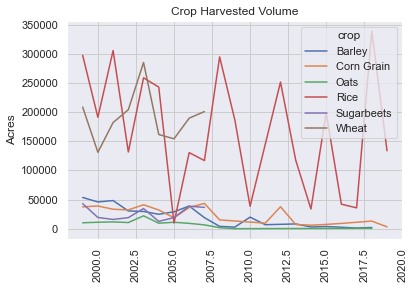

In [187]:
harvested = ag_diff("ACRES_HARVESTED", final_wf_ag_pric)

harv_cali = harvested.groupby(by=["State", "Ig_Date_Year", "crop"], dropna=False, as_index=False).agg({'ACRES_HARVESTED':'sum', 'ACRES_HARVESTED_diff':'mean'})

sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.lineplot(data=harv_cali, x="Ig_Date_Year", y="ACRES_HARVESTED", hue="crop", sort=False)

# Customise some display properties
ax.set_title('Crop Harvested Volume')
ax.grid(color='#cccccc')
ax.set_ylabel('Acres')
ax.set_xlabel(None)
plt.xticks(rotation='vertical')

#plt.savefig(results_bucket+'followers_count_change_daily_susvsns.png', bbox_inches='tight')
# Ask Matplotlib to show it
plt.show()

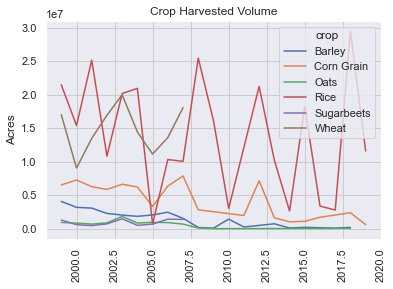

In [188]:
prod  = ag_diff("PRODUCTION", final_wf_ag_pric)

prod_cali = prod.groupby(by=["State", "Ig_Date_Year", "crop"], dropna=False, as_index=False).agg({'PRODUCTION':'sum', 'PRODUCTION_diff':'mean'})

sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.lineplot(data=prod_cali, x="Ig_Date_Year", y="PRODUCTION", hue="crop", sort=False)

# Customise some display properties
ax.set_title('Crop Harvested Volume')
ax.grid(color='#cccccc')
ax.set_ylabel('Acres')
ax.set_xlabel(None)
plt.xticks(rotation='vertical')

#plt.savefig(results_bucket+'followers_count_change_daily_susvsns.png', bbox_inches='tight')
# Ask Matplotlib to show it
plt.show()

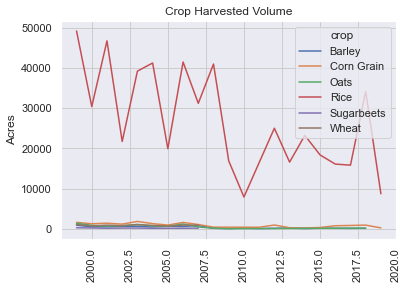

In [189]:
yiel = ag_diff("YIELD", final_wf_ag_pric)

yiel_cali = yiel.groupby(by=["State", "Ig_Date_Year", "crop"], dropna=False, as_index=False).agg({'YIELD':'sum', 'YIELD_diff':'mean'})

sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.lineplot(data=yiel_cali, x="Ig_Date_Year", y="YIELD", hue="crop", sort=False)

# Customise some display properties
ax.set_title('Crop Harvested Volume')
ax.grid(color='#cccccc')
ax.set_ylabel('Acres')
ax.set_xlabel(None)
plt.xticks(rotation='vertical')

#plt.savefig(results_bucket+'followers_count_change_daily_susvsns.png', bbox_inches='tight')
# Ask Matplotlib to show it
plt.show()

Merge in Diff DFs

In [190]:
final_wf_ag_pric = pd.merge(final_wf_ag_pric, planted[['Ig_Date_Year',"State","NAME", "crop","ACRES_PLANTED_diff"]], how = 'left', on=['Ig_Date_Year',"State","NAME", "crop"])

final_wf_ag_pric = pd.merge(final_wf_ag_pric, harvested[['Ig_Date_Year',"State","NAME", "crop","ACRES_HARVESTED_diff"]], how = 'left', on=['Ig_Date_Year',"State","NAME", "crop"])

final_wf_ag_pric = pd.merge(final_wf_ag_pric, prod[['Ig_Date_Year',"State","NAME", "crop","PRODUCTION_diff"]], how = 'left', on=['Ig_Date_Year',"State","NAME", "crop"])

final_wf_ag_pric = pd.merge(final_wf_ag_pric, yiel[['Ig_Date_Year',"State","NAME", "crop","YIELD_diff"]], how = 'left', on=['Ig_Date_Year',"State","NAME", "crop"])

In [191]:
final_wf_ag_pric.head()

,NAME,COUNTYFP,COUNTYNS,STATEFP,GEOID,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,total_area,INTPTLAT,INTPTLON,Incid_Type,Ig_Date_Year,Event_ID,BurnBndAc,dNBR_offst,dNBR_stdDv,IncGreen_T,Low_T,Mod_T,High_T,approx_county_acres_burned,intersect_area_prop,row_id,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Domain,Domain Category,CV (%),crop,ACRES_PLANTED,ACRES_HARVESTED,PRODUCTION,YIELD,ACRES_PLANTED_NET,PERCENT,year,Crop,Alfalfa,All Other,Price per bushel,Price per cwt,Price per gallon,Price per pound,Price per ton,Value of production,Value of utilized production,Price,ACRES_PLANTED_diff,ACRES_HARVESTED_diff,PRODUCTION_diff,YIELD_diff
0,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39317.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,400.0,0.0,0.0,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN,NaN,NaN,400.0,61000.0,152.5
1,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39317.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,400.0,0.0,0.0,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN,NaN,NaN,400.0,61000.0,-152.5
2,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39317.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,400.0,0.0,0.0,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN,NaN,NaN,400.0,-61000.0,152.5
3,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39317.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,400.0,0.0,0.0,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN,NaN,NaN,400.0,-61000.0,-152.5
4,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39317.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,400.0,0.0,0.0,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN,NaN,NaN,-400.0,61000.0,152.5


Lag Fire Damage 

In [192]:
county_fires = final_wf_ag_pric.groupby(by=["State", "Ig_Date_Year", "NAME"], dropna=False, as_index=False).agg({'approx_county_acres_burned':'sum'})
county_fires = county_fires.rename(columns={"approx_county_acres_burned": "annual_county_burns"})
county_fires.head()

,State,Ig_Date_Year,NAME,annual_county_burns
0,California,1999,Alpine,27.352679
1,California,1999,Butte,51465.615662
2,California,1999,Colusa,85454.705896
3,California,1999,Fresno,2163.823390
4,California,1999,Inyo,2.626549


In [193]:
county_fires['annual_county_burns_diff'] = county_fires.sort_values(['Ig_Date_Year', 'State','NAME'], ascending = (False, False,False))['annual_county_burns'].diff()

In [194]:
final_wf_ag_pric = pd.merge(final_wf_ag_pric, county_fires, how = 'left', on=['Ig_Date_Year',"State","NAME"])

In [195]:
final_wf_ag_pric.head()

,NAME,COUNTYFP,COUNTYNS,STATEFP,GEOID,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,total_area,INTPTLAT,INTPTLON,Incid_Type,Ig_Date_Year,Event_ID,BurnBndAc,dNBR_offst,dNBR_stdDv,IncGreen_T,Low_T,Mod_T,High_T,approx_county_acres_burned,intersect_area_prop,row_id,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Domain,Domain Category,CV (%),crop,ACRES_PLANTED,ACRES_HARVESTED,PRODUCTION,YIELD,ACRES_PLANTED_NET,PERCENT,year,Crop,Alfalfa,All Other,Price per bushel,Price per cwt,Price per gallon,Price per pound,Price per ton,Value of production,Value of utilized production,Price,ACRES_PLANTED_diff,ACRES_HARVESTED_diff,PRODUCTION_diff,YIELD_diff,annual_county_burns,annual_county_burns_diff
0,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39317.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,400.0,0.0,0.0,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN,NaN,NaN,400.0,61000.0,152.5,5173.688866,5156.272368
1,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39317.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,400.0,0.0,0.0,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN,NaN,NaN,400.0,61000.0,-152.5,5173.688866,5156.272368
2,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39317.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,400.0,0.0,0.0,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN,NaN,NaN,400.0,-61000.0,152.5,5173.688866,5156.272368
3,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39317.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,400.0,0.0,0.0,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN,NaN,NaN,400.0,-61000.0,-152.5,5173.688866,5156.272368
4,Alameda,001,01675839,06,06001,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,2127222720,+37.6471385,-121.9124880,Wildfire,2003,1,4975,36.0,NaN,-150.0,120.0,252.0,440.0,58.131336,0.011685,39317.0,SURVEY,2003.0,YEAR,NaN,COUNTY,California,6.0,CENTRAL COAST,40.0,Alameda,1.0,NaN,NaN,0.0,NaN,CORN,TOTAL,NOT SPECIFIED,NaN,Corn Grain,NaN,400.0,0.0,0.0,0.0,NaN,2003.0,Corn Grain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77520,NaN,NaN,NaN,-400.0,61000.0,152.5,5173.688866,5156.272368


In [1002]:
final_wf_ag_pric.to_csv('final_ag_price_final.csv', index=False, encoding = "utf_8_sig")